# International Trade Network Analysis: Understanding Global Economic Interactions

International trade forms the backbone of the global economy, facilitating the exchange of goods, services, and resources between countries. The intricate web of trade relationships not only impacts national economies but also influences global economic stability and growth. Understanding these relationships is crucial for policymakers, economists, and business leaders alike. In this context, network analysis provides a powerful tool to unravel the complexities of international trade.

International trade networks are dynamic and complex. By analyzing these networks, we can uncover patterns, trends, and key players that shape global trade. Through centrality measures we can identify countries that play a central role in the trade network. These central countries often act as major hubs, influencing trade flows and economic policies.

In [3]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import csv

In [4]:
with open(r'C:\Users\the_s\Desktop\AI Master\Social Network Analysis\countries.json', 'r') as file:
    data = json.load(file)

## Data Preprocessing

In [6]:
key_mapping = {
        "Economy: Real GDP (purchasing power parity)": "GDP",
        "Economy: GDP - composition, by end use - exports of goods and services": "GDP Exports",
        "Economy: GDP - composition, by end use - imports of goods and services": "GDP Imports",
        "Economy: Exports": "Exports",
        "Economy: Exports - partners": "Export Partners",
        "Economy: Exports - commodities": "Export Commodities",
        "Economy: Imports": "Imports",
        "Economy: Imports - partners": "Import Partners",
        "Economy: Imports - commodities": "Import Commodities"
    }
old_keys = list(key_mapping.keys())

data = {country: data[country] for country in data if all(key in data[country] for key in old_keys)}

In [7]:
for country, country_data in data.items():
        filtered_renamed_data = {key_mapping.get(key, key): value for key, value in country_data.items() if key in old_keys}
        data[country] = filtered_renamed_data

for country_data in data.values():
    for key, value in country_data.items():
        tempval = value.split(' (')[0]
        country_data[key] = tempval.strip('%')
        
for country_data in data.values():
    export_partners_str = country_data['Export Partners']
    export_partners = export_partners_str.split(', ')

    export_partner_associations = {}

    for partner_str in export_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]
        percentage = partner_str[last_space_index+1:]
        percentage = percentage.replace(',', '')
        percentage = percentage.replace('%', '')

        export_partner_associations[partner] = percentage
        
    country_data['Export Partners'] = export_partner_associations

    import_partners_str = country_data['Import Partners']
    import_partners = import_partners_str.split(', ')

    import_partner_associations = {}

    for partner_str in import_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]
        percentage = partner_str[last_space_index+1:]
        percentage = percentage.replace(',', '')
        percentage = percentage.replace('%', '')

        import_partner_associations[partner] = percentage

    country_data['Import Partners'] = import_partner_associations

In [8]:
print(data['Afghanistan'])

{'GDP': '$60.802 billion', 'GDP Exports': '6.7', 'GDP Imports': '-47.6', 'Exports': '$1.476 billion', 'Export Partners': {'United Arab Emirates': '45', 'Pakistan': '24', 'India': '22', 'China': '1'}, 'Export Commodities': 'gold, figs, grapes, cotton, fruits and nuts, coal', 'Imports': '$6.983 billion', 'Import Partners': {'United Arab Emirates': '23', 'Pakistan': '17', 'India': '13', 'Uzbekistan': '7', 'China': '9'}, 'Import Commodities': 'wheat flours, broadcasting equipment, refined petroleum, rolled tobacco, aircraft parts, synthetic fabrics'}


In [9]:
country_mapping = {
    'UK': 'United Kingdom',
    'US': 'United States',
    'UAE': 'United Arab Emirates',
    'Gambia, The': 'Gambia',
    'Turkey (Turkiye)': 'Turkey',
    'Congo, Democratic Republic of the': 'Congo',
    'Democratic Republic of the Congo': 'Congo',
    'Congo, Republic of the': 'Congo',
    'Republic of the Congo': 'Congo',
    'Korea, South': 'South Korea',
    'Korea, North': 'North Korea',
    'Cost Rica': 'Costa Rica',
    'NZ': 'New Zealand',
    'Micronesia, Federated States of': 'Micronesia'
}

### Dataframes Creation

In [11]:
### Exports df
export_data = []
for country, exports in data.items():
    export_partners = exports.get('Export Partners', {})
    for partner, weight in export_partners.items():
        if partner in country_mapping:
            partner = country_mapping[partner]
        
        if country in country_mapping:
            country = country_mapping[country]
        

        
        export_data.append({'source': country, 'target': partner, 'weight': float(weight)})
        

exports_df = pd.DataFrame(export_data)
exports_df

,source,target,weight
0,Afghanistan,United Arab Emirates,45.0
1,Afghanistan,Pakistan,24.0
2,Afghanistan,India,22.0
3,Afghanistan,China,1.0
4,Albania,Italy,45.0
...,...,...,...
971,Zambia,Congo,9.0
972,Zambia,Singapore,8.0
973,Zimbabwe,United Arab Emirates,40.0
974,Zimbabwe,South Africa,23.0


In [19]:
### Imports df
import_data = []
for country, imports in data.items():
    import_partners = imports.get('Import Partners', {})
    for partner, weight in import_partners.items():
        if partner in country_mapping:
            partner = country_mapping[partner]
        
        if country in country_mapping:
            country = country_mapping[country]

        
        import_data.append({'source': country, 'target': partner, 'weight': float(weight)})

imports_df = pd.DataFrame(import_data)
imports_df

,source,target,weight
0,Afghanistan,United Arab Emirates,23.0
1,Afghanistan,Pakistan,17.0
2,Afghanistan,India,13.0
3,Afghanistan,Uzbekistan,7.0
4,Afghanistan,China,9.0
...,...,...,...
1000,Zambia,Congo,6.0
1001,Zambia,India,5.0
1002,Zimbabwe,South Africa,41.0
1003,Zimbabwe,Singapore,23.0


## Networks

Analyzing both import and export networks separately allows us to understand the different roles countries play in global trade. Some countries might be central in the export network but peripheral in the import network, and vice versa.

In [23]:
# Create directed graphs for imports and exports
G_imports = nx.DiGraph()
G_exports = nx.DiGraph()

# Add edges from exports
for _, row in exports_df.iterrows():
    G_exports.add_edge(row['source'], row['target'], weight=row['weight'])

# Add edges from imports
for _, row in imports_df.iterrows():
    G_imports.add_edge(row['source'], row['target'], weight=row['weight'])

# Check number of nodes
num_nodes_export = G_exports.number_of_nodes()
num_nodes_import = G_imports.number_of_nodes()
print(f"Number of nodes in export graph: {num_nodes_export}")
print(f"Number of nodes in import graph: {num_nodes_import}")

Number of nodes in export graph: 209
Number of nodes in import graph: 207


In [25]:
nodes_export = set(G_exports.nodes())
nodes_import = set(G_imports.nodes())

common_nodes = nodes_export.intersection(nodes_import)

print(f"Number of common nodes: {len(common_nodes)}")

Number of common nodes: 207


In [27]:
# Create subgraphs with only the common nodes
G_export = G_exports.subgraph(common_nodes).copy()
G_import = G_imports.subgraph(common_nodes).copy()

eliminated_from_exports = nodes_export - common_nodes
eliminated_from_imports = nodes_import - common_nodes

print(f"Nodes eliminated from export graph: {eliminated_from_exports}")
print(f"Nodes eliminated from import graph: {eliminated_from_imports}")

Nodes eliminated from export graph: {'Martinique', 'Guadeloupe'}
Nodes eliminated from import graph: set()


# Measures

## Degree Centrailty

Degree centrality measures the number of direct connections a node has. In the context of a trade network, it indicates the number of trade partners a country has. A higher degree centrality means that a country has more direct trade relationships, suggesting its central role in the network.

-----Exports Network-----


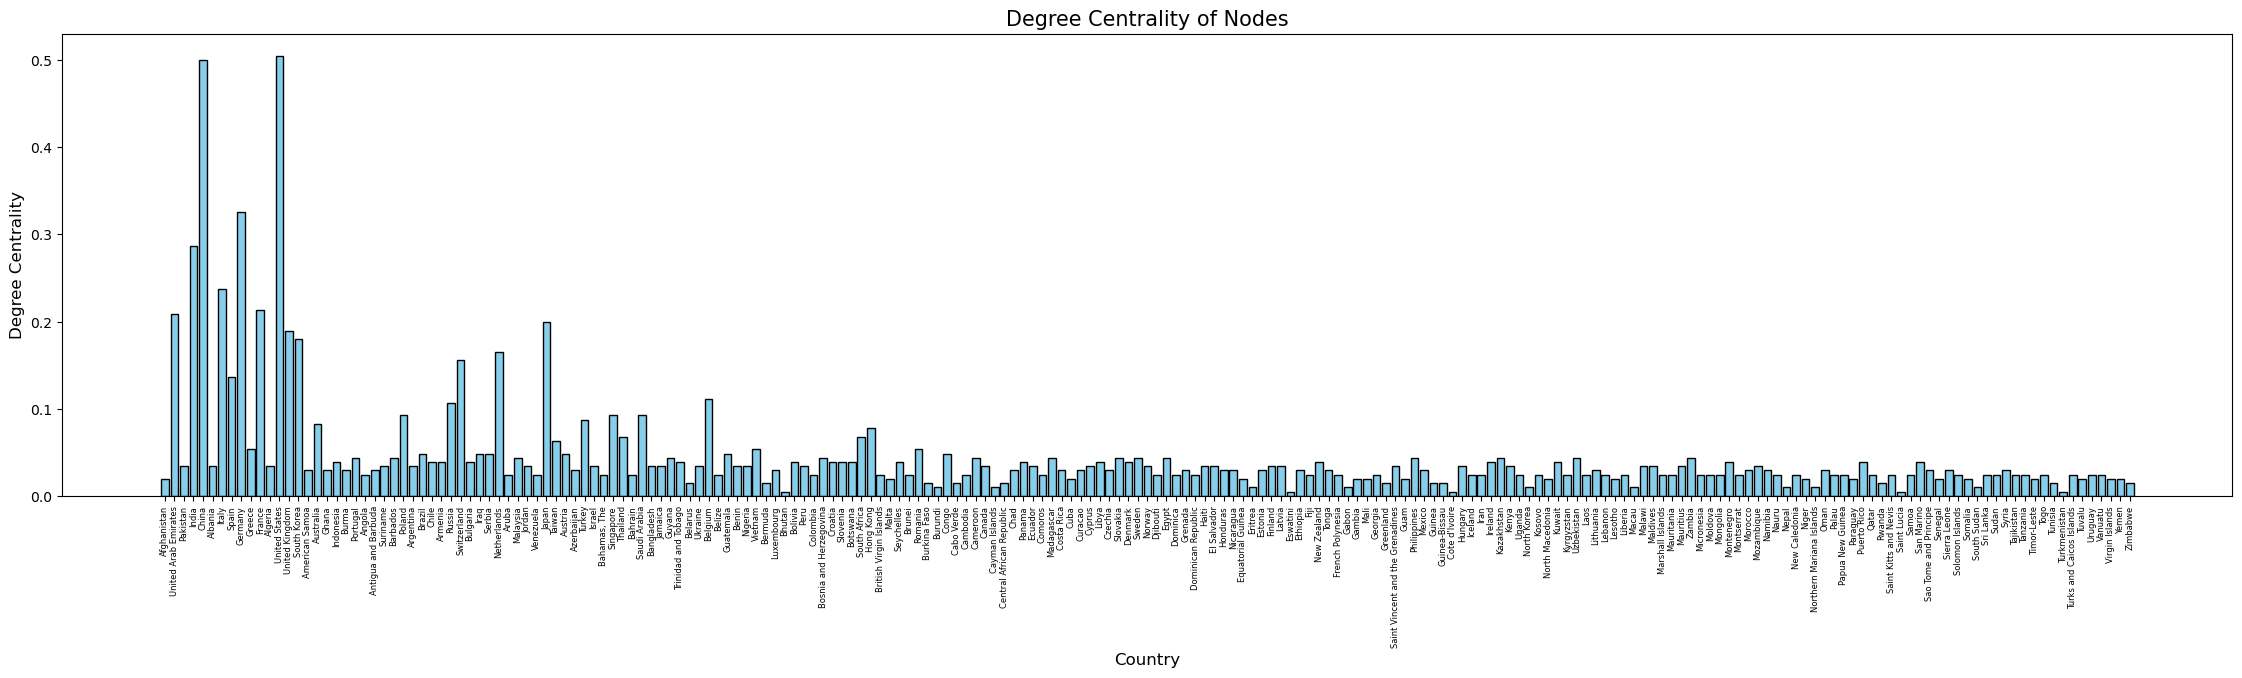

Nodes (Countries) with High Degree Centrality (> 0.2):
United Arab Emirates: 0.2087
India: 0.2864
China: 0.5000
Italy: 0.2379
Germany: 0.3252
France: 0.2136
United States: 0.5049


In [63]:
degree_centrality_export = nx.degree_centrality(G_export)
degree_centrality_import = nx.degree_centrality(G_import)

degree_centrality_values_export = list(degree_centrality_export.values())
degree_centrality_values_import = list(degree_centrality_import.values())

# Plot histogram
def centrality(cent, centrality_values, type, threshold, color='skyblue'):
    countries = cent.keys()
    plt.figure(figsize=(28, 6))
    plt.bar(countries, centrality_values, color=color, edgecolor='black')
    plt.xticks(rotation=90, fontsize=6)
    plt.title(type+' of Nodes', fontsize=15)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel(type, fontsize=12)
    plt.show()

    high_centrality_nodes = {node: centrality for node, centrality in cent.items() if centrality > threshold}
    print('Nodes (Countries) with High '+type+' (> '+str(threshold)+'):')
    for node, centrality in high_centrality_nodes.items():
        print(f"{node}: {centrality:.4f}")
    return high_centrality_nodes
    
print("-----Exports Network-----")
high_degree_nodes_export = centrality(degree_centrality_export, degree_centrality_values_export, type='Degree Centrality',threshold=0.2)

China and the United States are the most central nodes, indicating they have the highest number of direct trade connections.
European countries like Germany, Italy, and France also have high centrality, highlighting their significant role in the global export network.
Smaller countries or those with specific economic profiles (e.g., Bhutan: 0.0049, Eswatini: 0.0049) have very low centrality, reflecting limited trade connections.

-----Imports Network-----


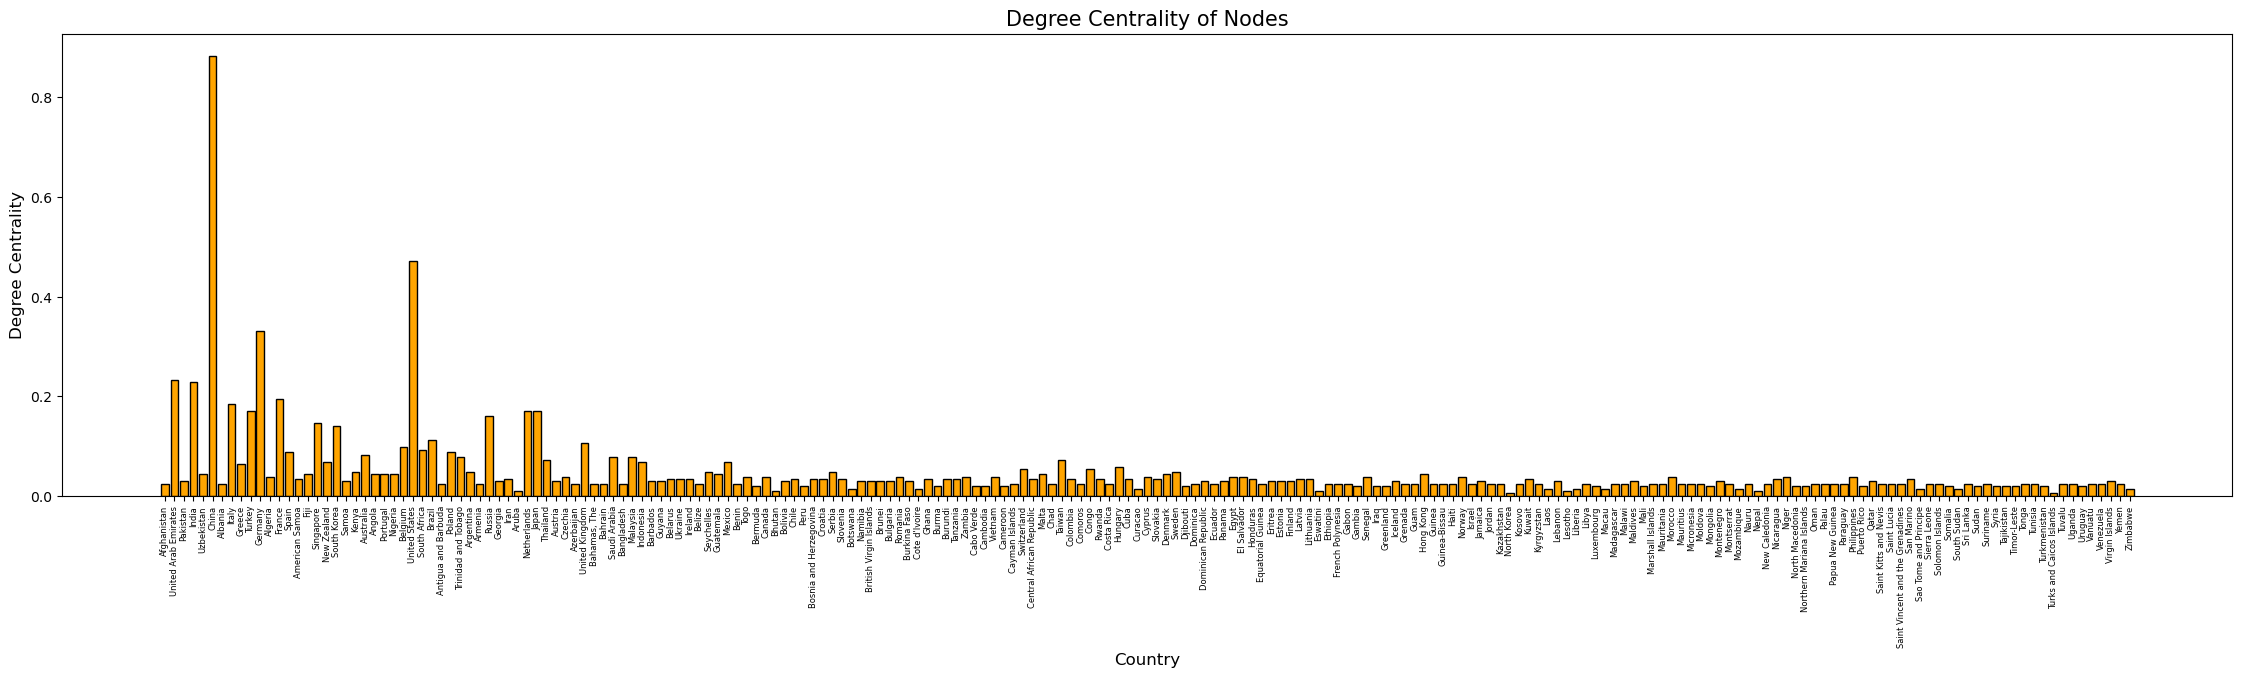

Nodes (Countries) with High Degree Centrality (> 0.2):
United Arab Emirates: 0.2330
India: 0.2282
China: 0.8835
Germany: 0.3301
United States: 0.4709


In [65]:
print("-----Imports Network-----")
high_degree_nodes_import = centrality(degree_centrality_import, degree_centrality_values_import, type='Degree Centrality',threshold=0.2, color='orange')

China has an exceptionally high centrality, indicating a vast number of import connections, significantly higher than any other country.
The United States and Germany also play crucial roles in the imports network, though their centrality is less than that of China.
Smaller nations and island states generally have lower centrality values (e.g., North Korea: 0.0049, Lesotho: 0.0097), reflecting fewer trade links.

#### Comparative Analysis
Global Trade Hubs:
Both China and the United States emerge as major hubs in global trade, dominating both export and import networks.
European countries like Germany, Italy, and France are pivotal in exports, while Germany and the United Kingdom are also significant in imports.

Regional Influence:
The United Arab Emirates has a relatively high centrality in imports, highlighting its role as a major trading hub in the Middle East.
Asian countries like Japan, South Korea, and India have substantial centrality values, underscoring their active participation in global trade.

Economic Marginality:
Many smaller and less economically developed countries have low centrality values in both networks, indicating limited trade activity.
Some countries, despite their size or economic status, still manage to maintain a notable presence in trade networks, such as Singapore in the imports network (0.1456).

### Degree Centrailty Distribution

The degree centrality distribution is crucial for understanding the connectivity pattern within a trade network. Fitting this distribution to a power law can reveal whether the network has a scale-free structure, characterized by a few highly connected nodes (hubs) and many nodes with fewer connections. This is significant because it indicates the presence of dominant countries that act as major trade hubs, which can have substantial implications for network resilience, trade flow efficiency, and economic influence.

-----Exports Network-----


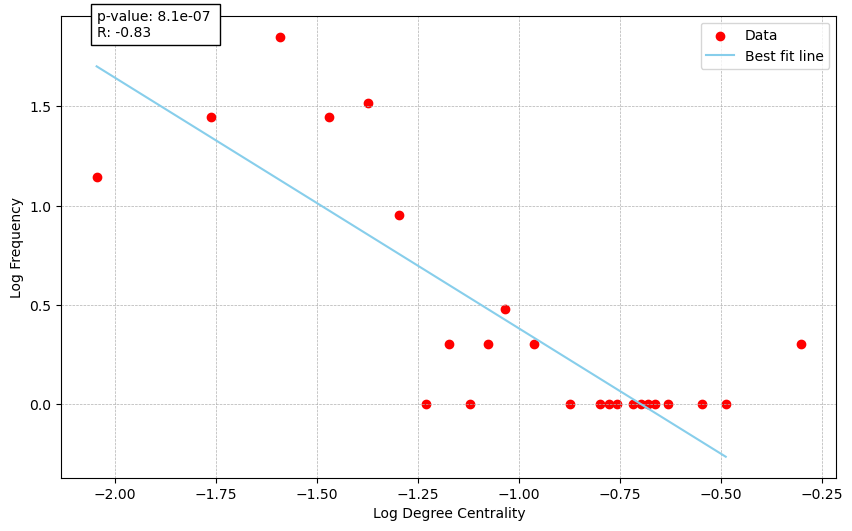

The slope of the line is: -1.2630009291737454

-----Imports Network-----


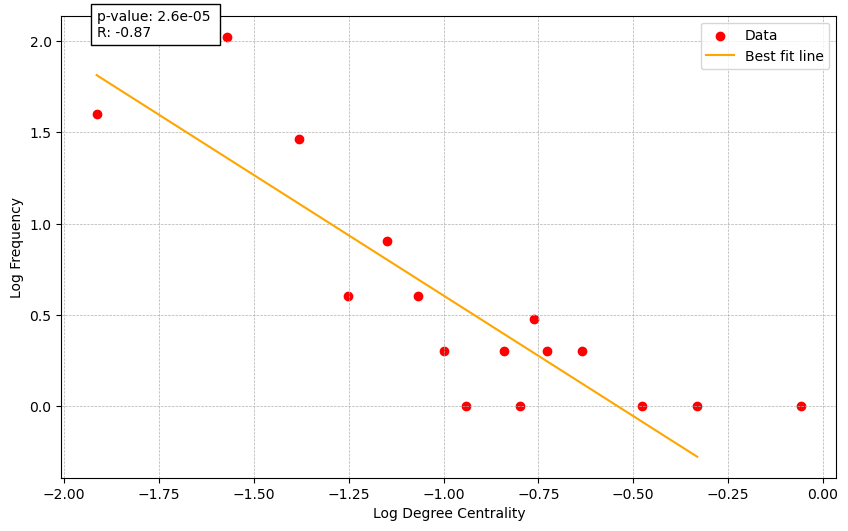

The slope of the line is: -1.322512036501067


In [70]:
def plot_centrality_power_law(centrality_values, G, bins, type, color):
    
    # Calculate histogram
    freq, bins = np.histogram(centrality_values, bins=bins)
    
    # Calculate bin centers
    x = (bins[:-1] + bins[1:]) / 2  # x = center value of each bin
    y = freq  # y = occurrence
    
    # Filter out zero values
    non_zero_indices = np.where(y > 0)
    x_display = x[non_zero_indices]
    y_display = y[non_zero_indices]
    
    # Exclude the last value for the fit (if it's an outlier)
    fit_points = np.where(x_display < np.max(x_display))
    x_fit = x_display[fit_points]
    y_fit = y_display[fit_points]
    
    # Take the logarithm of x and y
    log_x_display = np.log10(x_display)
    log_y_display = np.log10(y_display)
    log_x_fit = np.log10(x_fit)
    log_y_fit = np.log10(y_fit)
    
    # Fit a straight line to the data
    coeffs = np.polyfit(log_x_fit, log_y_fit, 1)
    
    # Generate y-values for the fitted line
    fitted_y = coeffs[0] * log_x_fit + coeffs[1]
    
    # Perform linear regression and get p-value
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_fit, log_y_fit)
    
    # Plot the data and the fit
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x_display, log_y_display, color='r', label='Data')
    plt.plot(log_x_fit, fitted_y, color, label='Best fit line')  # Plot fitted line
    plt.legend()
    plt.xlabel('Log '+type+' Centrality')
    plt.ylabel('Log Frequency')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.text(min(log_x_display), max(log_y_display), f'p-value: {p_value:.1e} \nR: {r_value:.2f}', bbox=dict(facecolor='white')) # Add p-value to the plot
    
    plt.show()
    
    print(f"The slope of the line is: {slope}")
    return slope
print("-----Exports Network-----")
slope = plot_centrality_power_law(degree_centrality_values_export, G_export, bins=60, type='Degree', color='skyblue')
print("\n-----Imports Network-----")
slope = plot_centrality_power_law(degree_centrality_values_import, G_import, bins=60, type='Degree', color='orange')

The negative slope values (-1.263 for exports and -1.323 for imports) indicate that as the degree centrality increases, the frequency of nodes with that centrality decreases. This is consistent with a power-law distribution, suggesting the presence of a few highly connected hubs and many nodes with fewer connections.

The very low p-values (8.1e-5 for exports and 2.6e-5 for imports) indicate that the observed relationship between the degree centrality and its frequency is statistically significant. This strengthens the evidence that the degree centrality follows a power-law distribution.

The high negative R-values (-0.83 for exports and -0.87 for imports) suggest a strong negative correlation between the log-transformed degree centrality and its frequency. This confirms the power-law behavior of the network, indicating that the trade network is likely to be scale-free.

The degree centrality distribution analysis reveals that both the export and import networks exhibit characteristics of scale-free networks. This means that a few countries (nodes) play a crucial role as major hubs in global trade, while many countries have fewer trade connections. Understanding this structure is vital for policy-making and economic strategies, as these hubs are critical for the stability and efficiency of the global trade network. Identifying and supporting these hubs can enhance global trade resilience and efficiency, while also highlighting potential vulnerabilities if these hubs were to be disrupted.

### Cumulative Distribution for Degree Centrality

-----Exports Network-----


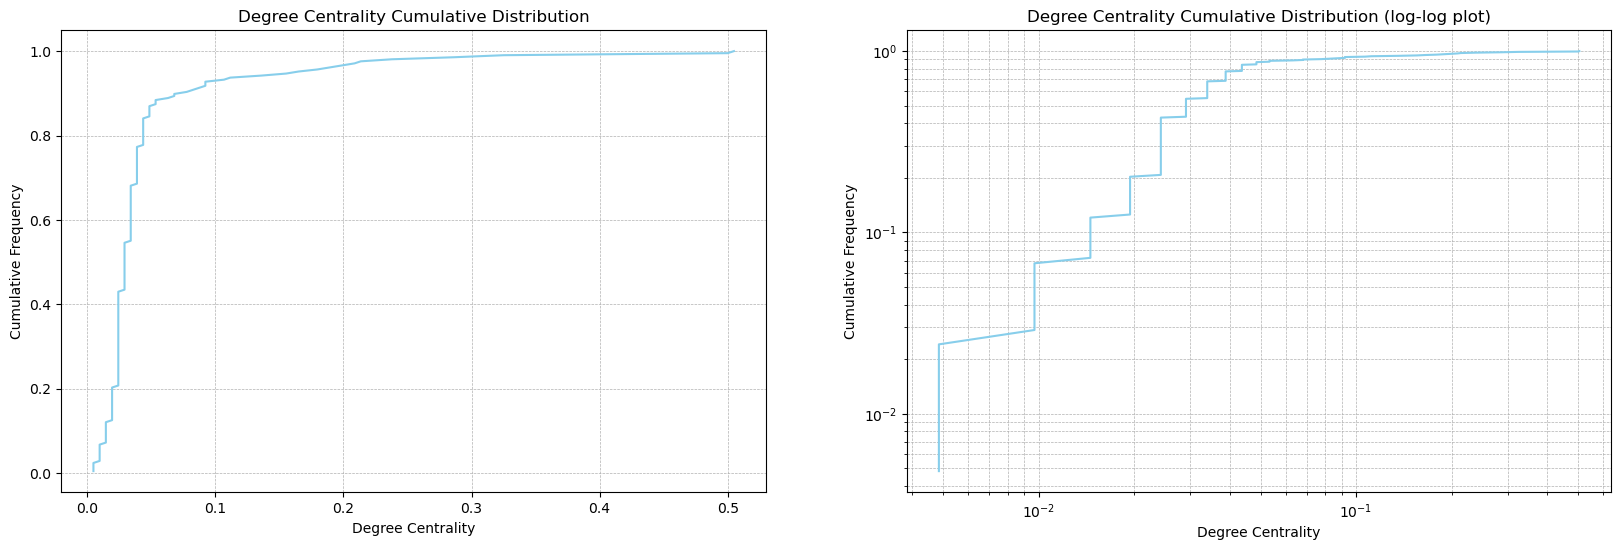

In [131]:
def cumulative_distribution(centrality_values,type,color):
    # Sort the degree centrality values
    sorted_centrality_values = np.sort(centrality_values)
    
    # Cumulative distribution
    cdf = np.arange(1, len(sorted_centrality_values) + 1) / len(sorted_centrality_values)
    
    # CDF Plot
    plt.figure(figsize=(20, 6))
    
    # Linear scale plot
    plt.subplot(1, 2, 1)
    plt.plot(sorted_centrality_values, cdf, color=color)
    plt.xlabel(type+' Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(type+' Centrality Cumulative Distribution')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    # Log-log scale plot
    plt.subplot(1, 2, 2)
    plt.plot(sorted_centrality_values, cdf, color=color)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(type+' Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(type+' Centrality Cumulative Distribution (log-log plot)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    #plt.savefig(color+'.png')
    plt.show()    
    
print("-----Exports Network-----")
cumulative_distribution(degree_centrality_values_export,type='Degree', color='skyblue')


-----Imports Network-----


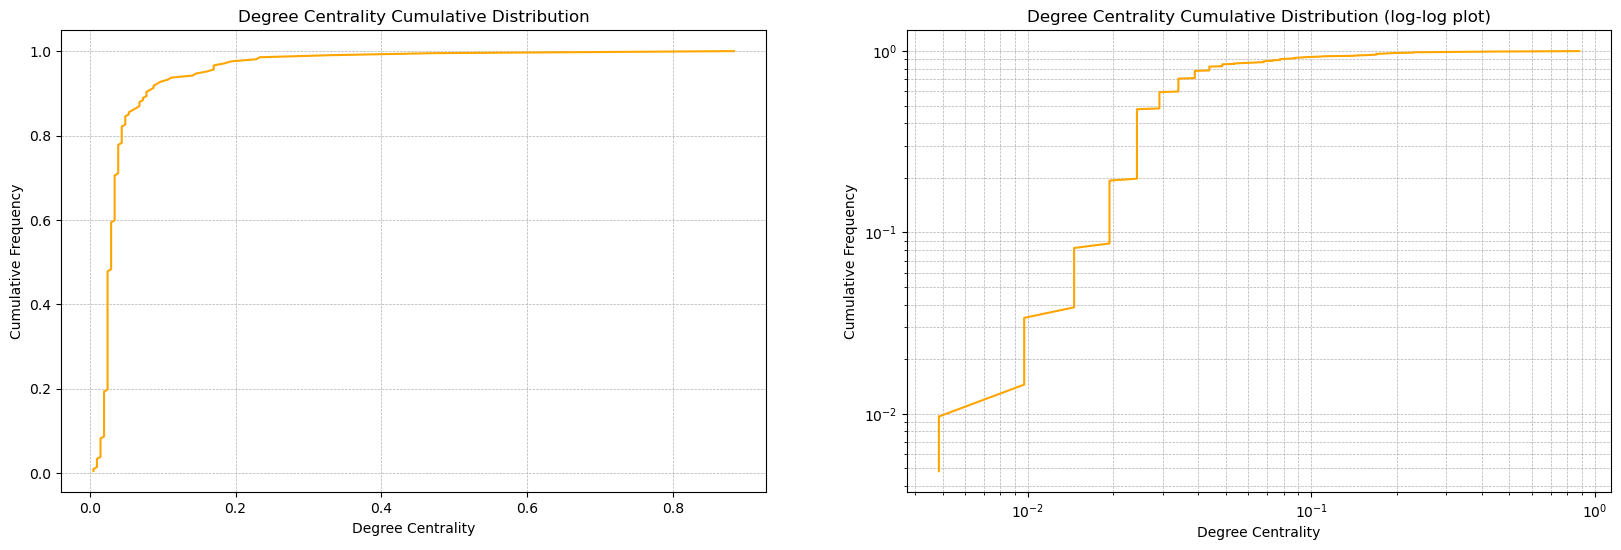

In [76]:
print("\n-----Imports Network-----")
cumulative_distribution(degree_centrality_values_import,type='Degree', color='orange')

In both the exports and the imports networks, the majority of countries have low degree centrality values, so most countries have a small number of direct trade connections, while a small number of countries have higher degree centrality values. The curves quickly rises at the beginning and then levels off, indicating that a few countries are highly connected while the rest have fewer connections.

Observing the log-log plots we can have more details about the distribution's tail: it shows a more linear trend in the middle range, suggesting a potential power-law distribution, as previously highlighted.

The steep rise in the CDF at low degree centrality values, followed by a gradual increase, suggests heterogeneous network structures where a few countries are significantly more connected than others. The presence of highly connected countries (high degree centrality) implies that these countries act as major hubs in both the network. These hubs are crucial for the stability and efficiency of global trade.


## Eigenvector centrality

Eigenvector centrality measures a node's influence based on the number and quality of its connections. In a trade network, it identifies countries that are not only well-connected but are connected to other highly influential countries. A higher eigenvector centrality suggests that a country is an important player in the global trade network, exerting significant economic influence.

-----Exports Network-----


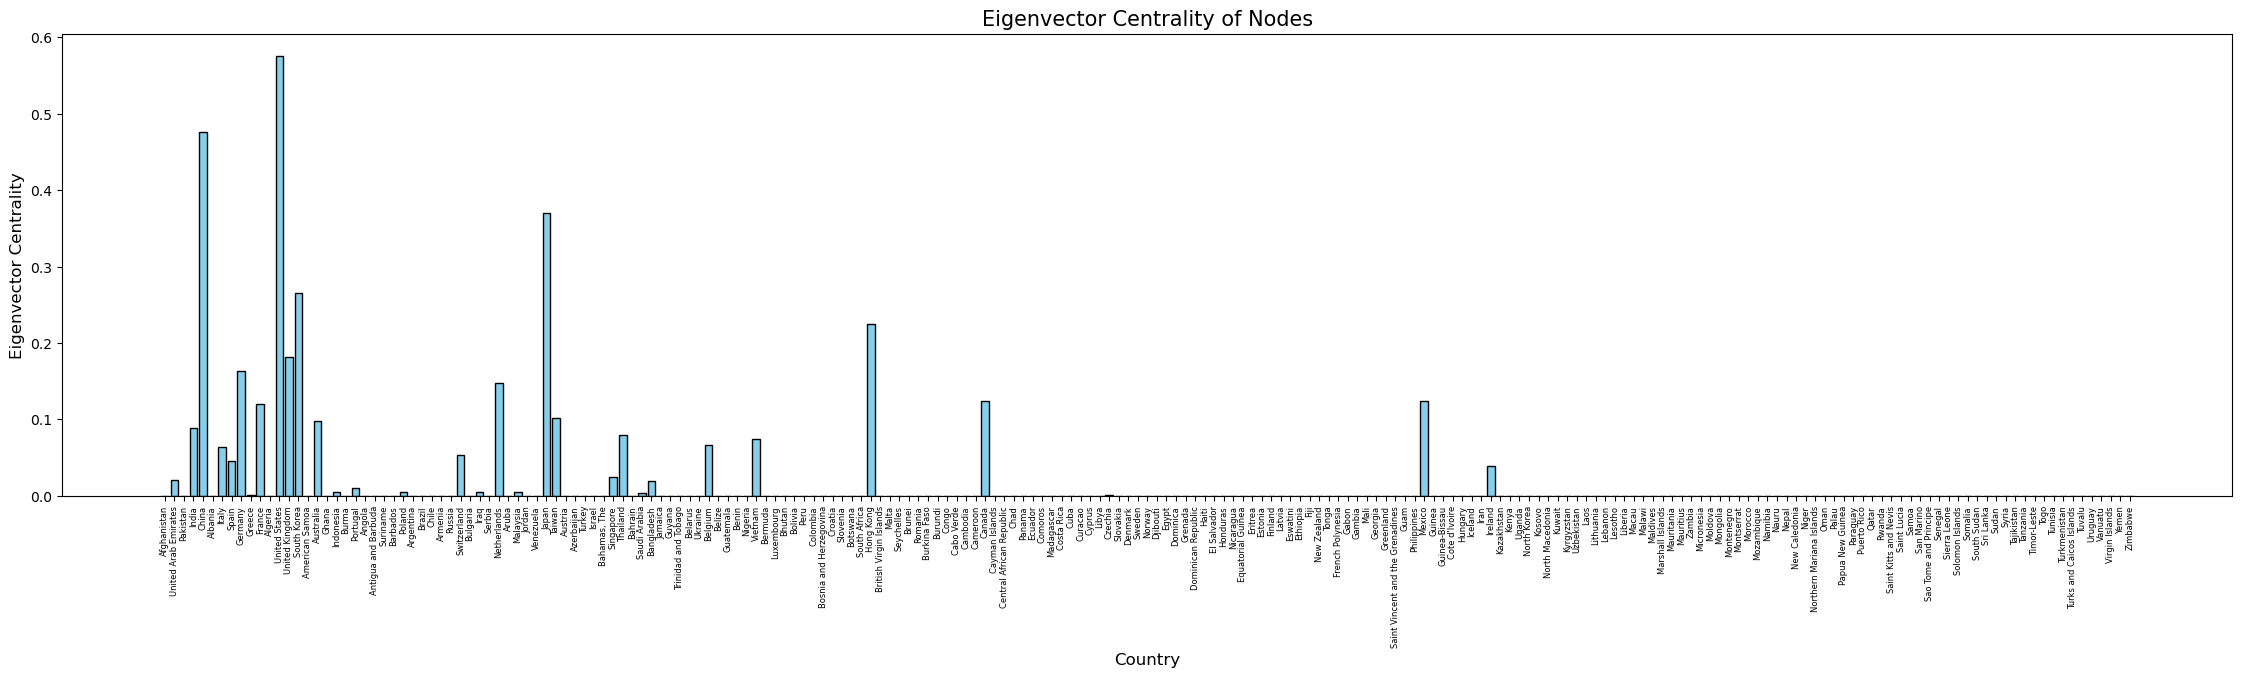

Nodes (Countries) with High Eigenvector Centrality (> 0.2):
China: 0.4764
United States: 0.5758
South Korea: 0.2661
Japan: 0.3699
Hong Kong: 0.2246


In [81]:
eigenvector_centrality_export = nx.eigenvector_centrality(G_export)
eigenvector_centrality_import = nx.eigenvector_centrality(G_import)

eigenvector_centrality_values_export = list(eigenvector_centrality_export.values())
eigenvector_centrality_values_import = list(eigenvector_centrality_import.values())

print("-----Exports Network-----")
high_eigenvector_nodes_export = centrality(eigenvector_centrality_export, eigenvector_centrality_values_export, type='Eigenvector Centrality',threshold=0.2, color='skyblue')

United States (0.5758) has the highest eigenvector centrality, indicating a very influential position in the exports network. The US is connected to other highly influential nodes, reinforcing its central role. The rest of the highest centrality countries belongs to the eastern side of the world: China (0.4764), followed by Japan (0.3699), South Korea (0.2661) and Hong Kong (0.2246).

-----Imports Network-----


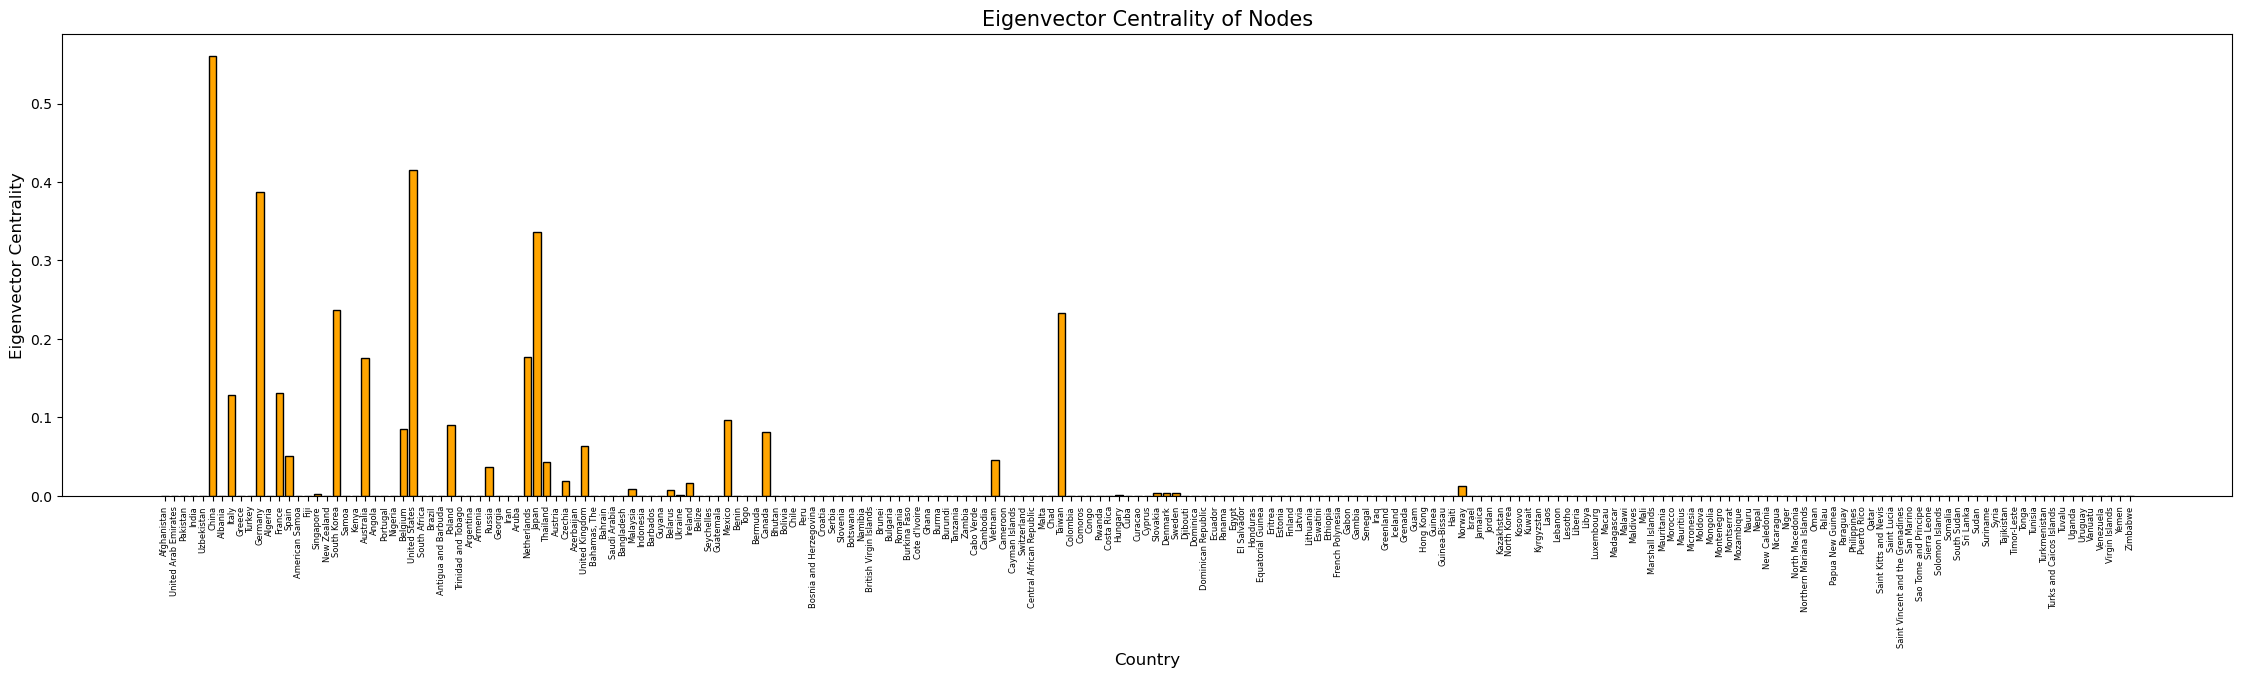

Nodes (Countries) with High Eigenvector Centrality (> 0.2):
China: 0.5607
Germany: 0.3870
South Korea: 0.2368
United States: 0.4158
Japan: 0.3361
Taiwan: 0.2325


In [88]:
print("-----Imports Network-----")
high_eigenvector_nodes_import = centrality(eigenvector_centrality_import, eigenvector_centrality_values_import, type='Eigenvector Centrality',threshold=0.2, color='orange')

By looking at the Eigenvector Centrality values of the Imports Network, we can immediately see that China (0.5607) and the United States (0.4158) swiched positions at the top, while still being the most two influential nodes. We notice a higher eigenvector centrality value in Germany (0.3870 in the imports network compared to 0.1636 in exports), demonstrating its higher influence.

#### Comparative Analysis
China and the United States are dominant in both exports and imports networks, reflecting their significant roles in global trade. Germany, Japan, and South Korea also feature prominently in both networks, indicating their importance.

Some countries have different roles in exports and imports. For example, Mexico and Canada are more influential in exports compared to imports. France and Italy have moderate influence in both networks but are more central in exports. European countries like Germany, the United Kingdom, and the Netherlands are fairly influential in both networks, highlighting Europe's critical role in global trade.

A significant number of countries have zero eigenvector centrality in both networks, indicating their limited role in global trade connections. These countries may have smaller economies, less diversified trade, or be more regionally focused.


### Eigenvector centrality distribution

-----Exports Network-----


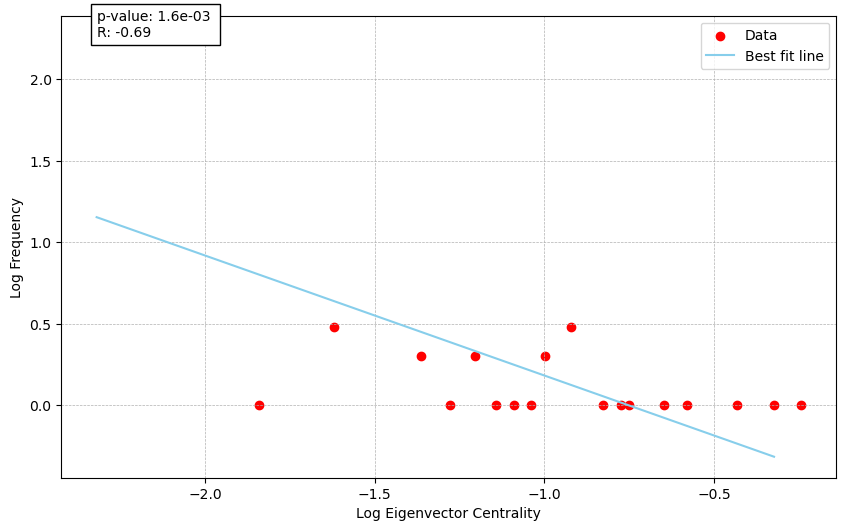

The slope of the line is: -0.7364451312092158

-----Imports Network-----


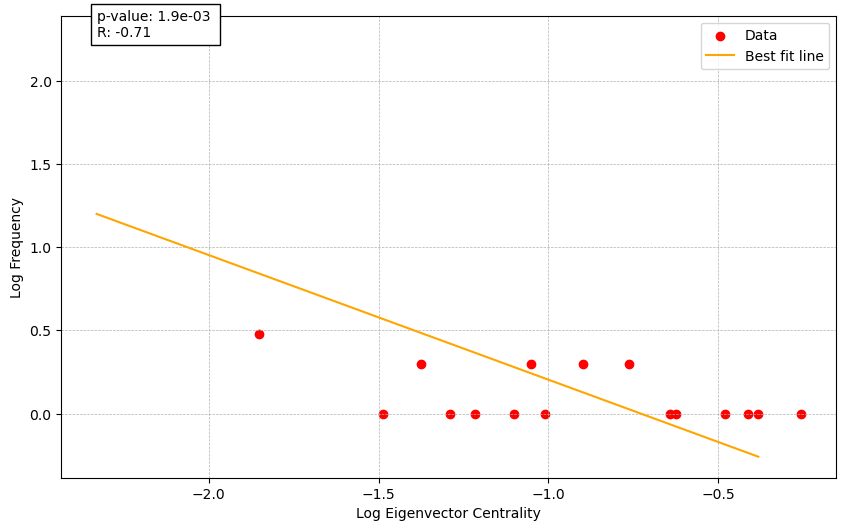

The slope of the line is: -0.749266711996696


In [92]:
print("-----Exports Network-----")
slope_e_export = plot_centrality_power_law(eigenvector_centrality_values_export, G_export, bins=60, type='Eigenvector', color='skyblue')
print("\n-----Imports Network-----")
slope_e_import = plot_centrality_power_law(eigenvector_centrality_values_import, G_import, bins=60, type='Eigenvector', color='orange')

The slopes for both networks are negative, indicating a decreasing trend. In a power-law distribution, this suggests that high eigenvector centrality values are less frequent, while lower values are more common.
The slopes are quite similar (-0.7364 for exports and -0.7493 for imports), indicating a similar rate of decay in the centrality distributions across both networks.

Both p-values (1.6e-03 for exports and 1.9e-03 for imports) are very low, indicating that the slope is statistically significant. This means the fit of the power-law model to the centrality data is robust.

The R-values (-0.69 for exports and -0.71 for imports) are negative and close to -0.7, indicating a moderate to strong negative correlation. This suggests that as the eigenvector centrality increases, the frequency of such nodes decreases, which is expected in networks where a few nodes have high centrality and many nodes have low centrality.

The analysis of the eigenvector centrality distributions for both the exports and imports networks demonstrates a typical power-law behavior. A few countries (nodes) dominate in terms of centrality, having significant influence and connections, while the majority have lower centrality values. This distribution is consistent with many real-world networks where influence or connectivity is not evenly distributed.

### Cumulative Distribution for Eigenvector Centrality

-----Exports Network-----


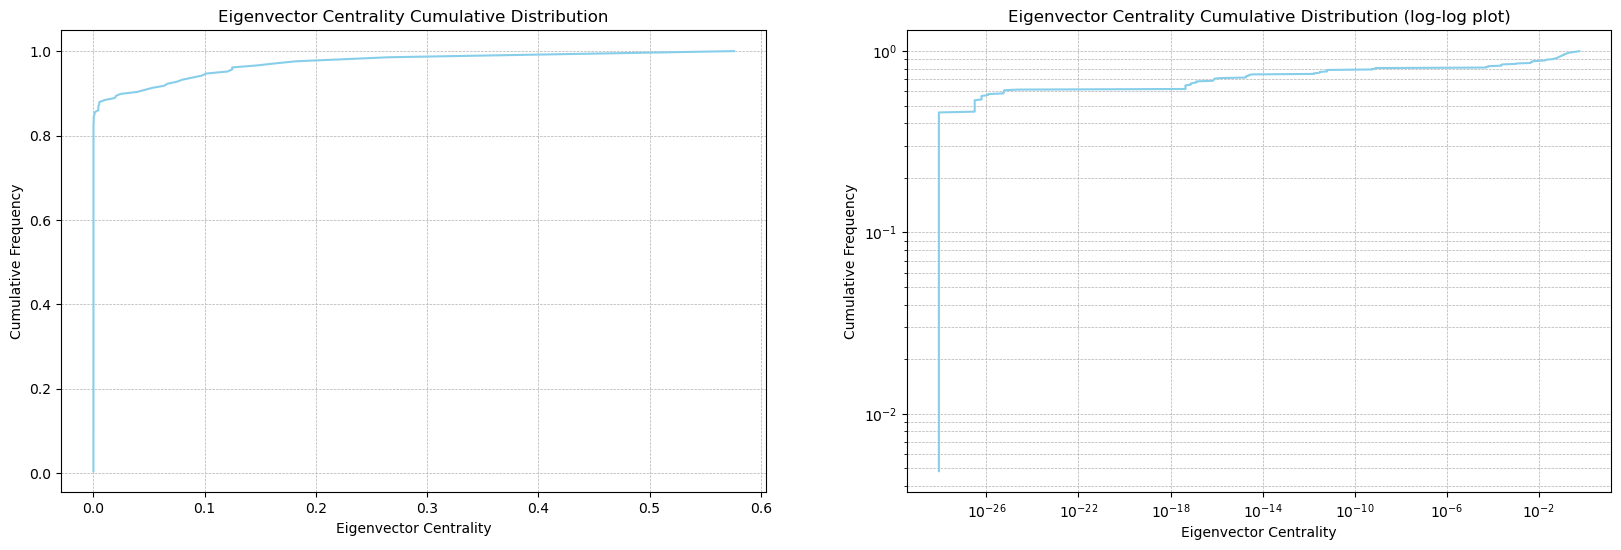


-----Imports Network-----


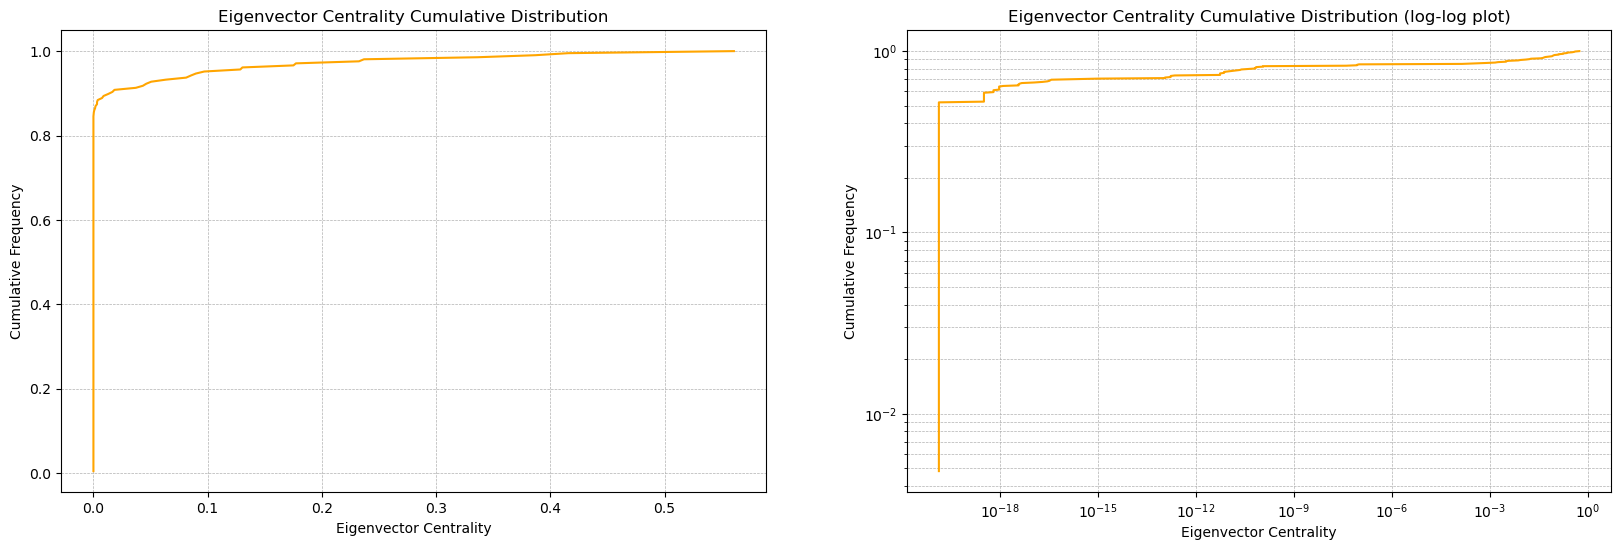

In [129]:
print("-----Exports Network-----")
cumulative_distribution(eigenvector_centrality_values_export,type='Eigenvector', color='skyblue')
print("\n-----Imports Network-----")
cumulative_distribution(eigenvector_centrality_values_import,type='Eigenvector', color='orange')

## Betweenness centrality

Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes. In trade networks, it indicates the countries that act as intermediaries in trade routes, controlling the flow of goods between other nations. A country with high betweenness centrality has significant influence over trade flow and can impact the efficiency of global trade routes.

-----Exports Network-----


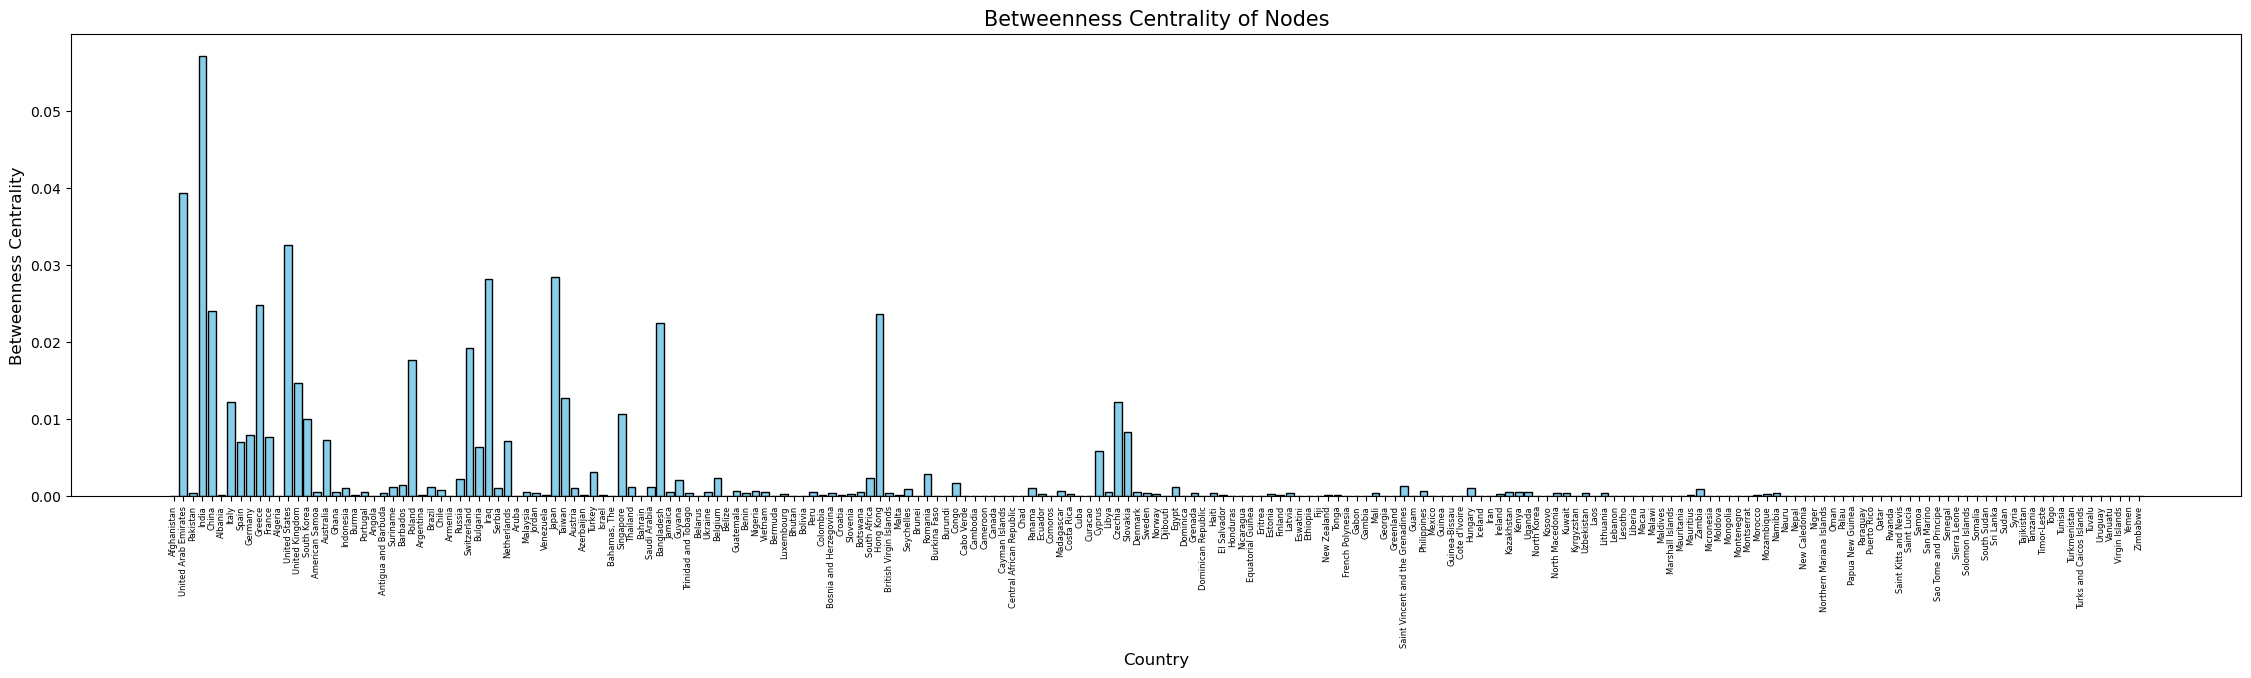

Nodes (Countries) with High Betweenness Centrality (> 0.015):
United Arab Emirates: 0.0393
India: 0.0571
China: 0.0240
Greece: 0.0248
United States: 0.0325
Poland: 0.0176
Switzerland: 0.0192
Iraq: 0.0282
Japan: 0.0284
Bangladesh: 0.0224
Hong Kong: 0.0236

-----Imports Network-----


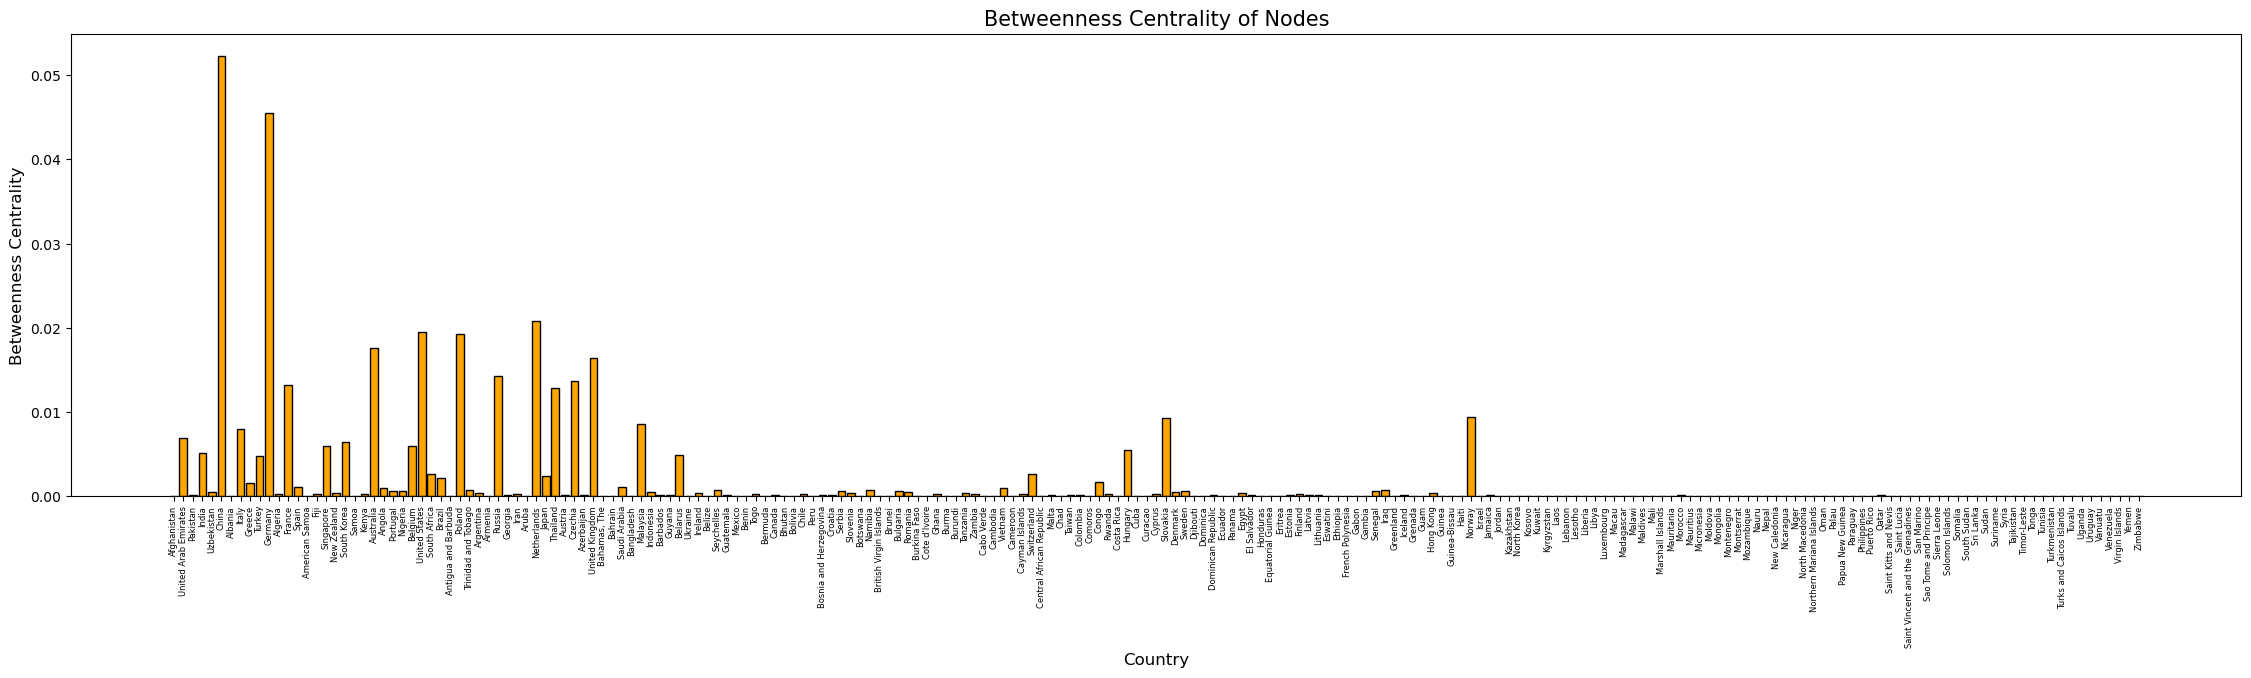

Nodes (Countries) with High Betweenness Centrality (> 0.015):
China: 0.0523
Germany: 0.0455
Australia: 0.0175
United States: 0.0195
Poland: 0.0192
Netherlands: 0.0208
United Kingdom: 0.0164


In [97]:
betweenness_centrality_export = nx.betweenness_centrality(G_export)
betweenness_centrality_import = nx.betweenness_centrality(G_import)

betweenness_centrality_values_export = list(betweenness_centrality_export.values())
betweenness_centrality_values_import = list(betweenness_centrality_import.values())

print("-----Exports Network-----")
high_betweenness_nodes_export = centrality(betweenness_centrality_export, betweenness_centrality_values_export, type='Betweenness Centrality',threshold=0.015, color='skyblue')
print("\n-----Imports Network-----")
high_betweenness_nodes_export = centrality(betweenness_centrality_import, betweenness_centrality_values_import, type='Betweenness Centrality',threshold=0.015, color='orange')

### Betweenness Centrality distribution

-----Exports Network-----


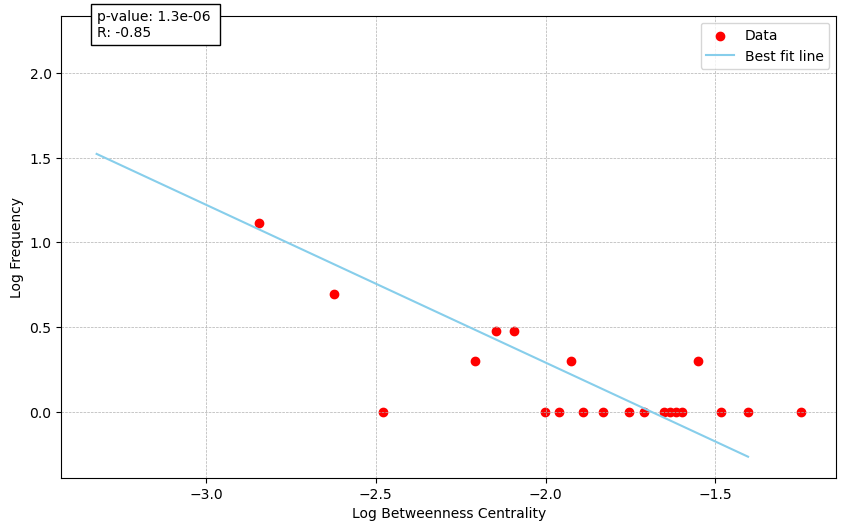

The slope of the line is: -0.9296039841746151
\Imports Graph


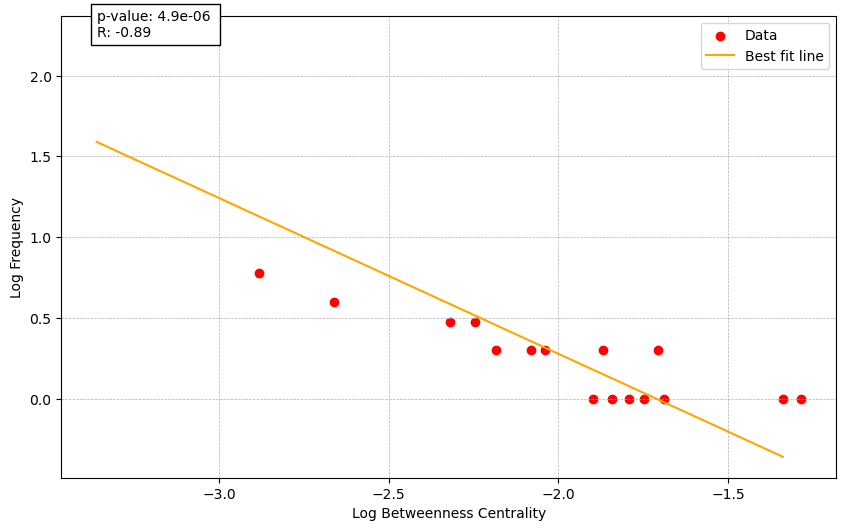

The slope of the line is: -0.9631881161012804


In [51]:
print("-----Exports Network-----")
slope_b_export = plot_centrality_power_law(betweenness_centrality_values_export, G_export, bins=60, type='Betweenness', color='skyblue')
print("\Imports Graph")
slope_b_import = plot_centrality_power_law(betweenness_centrality_values_import, G_import, bins=60, type='Betweenness', color='orange')

### Cumulative Distribution for Betweenness Centrality

-----Exports Network-----


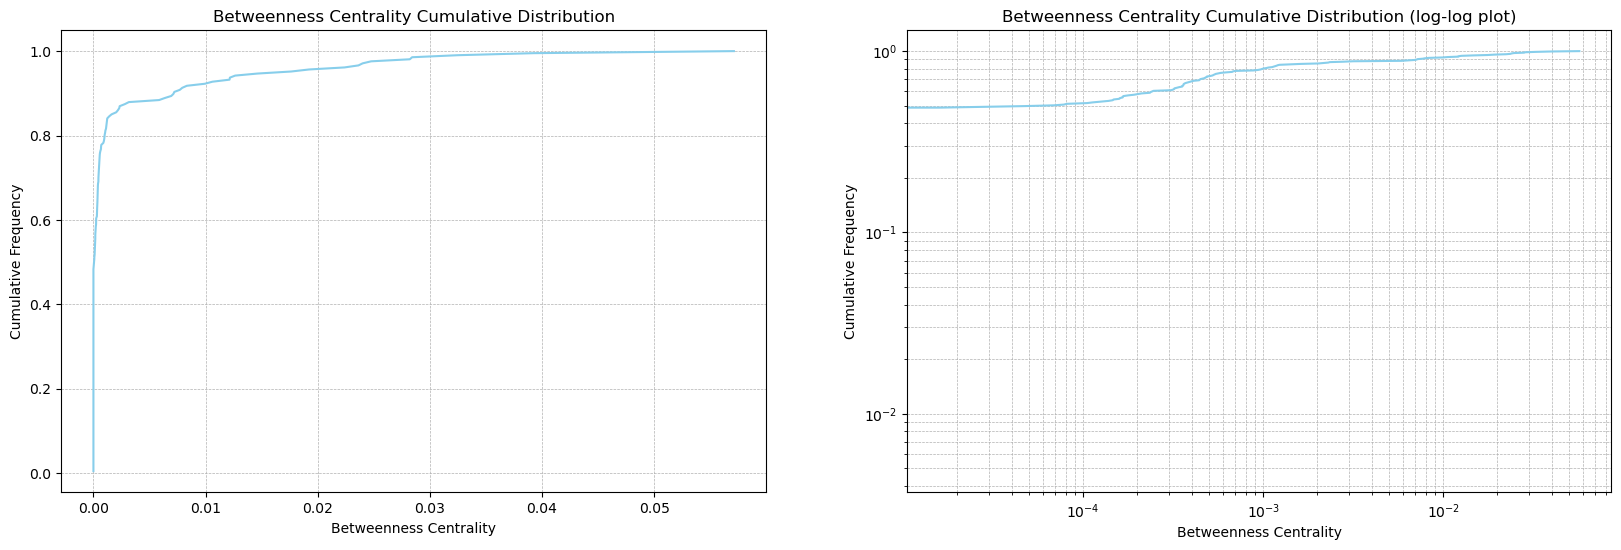


-----Imports Network-----


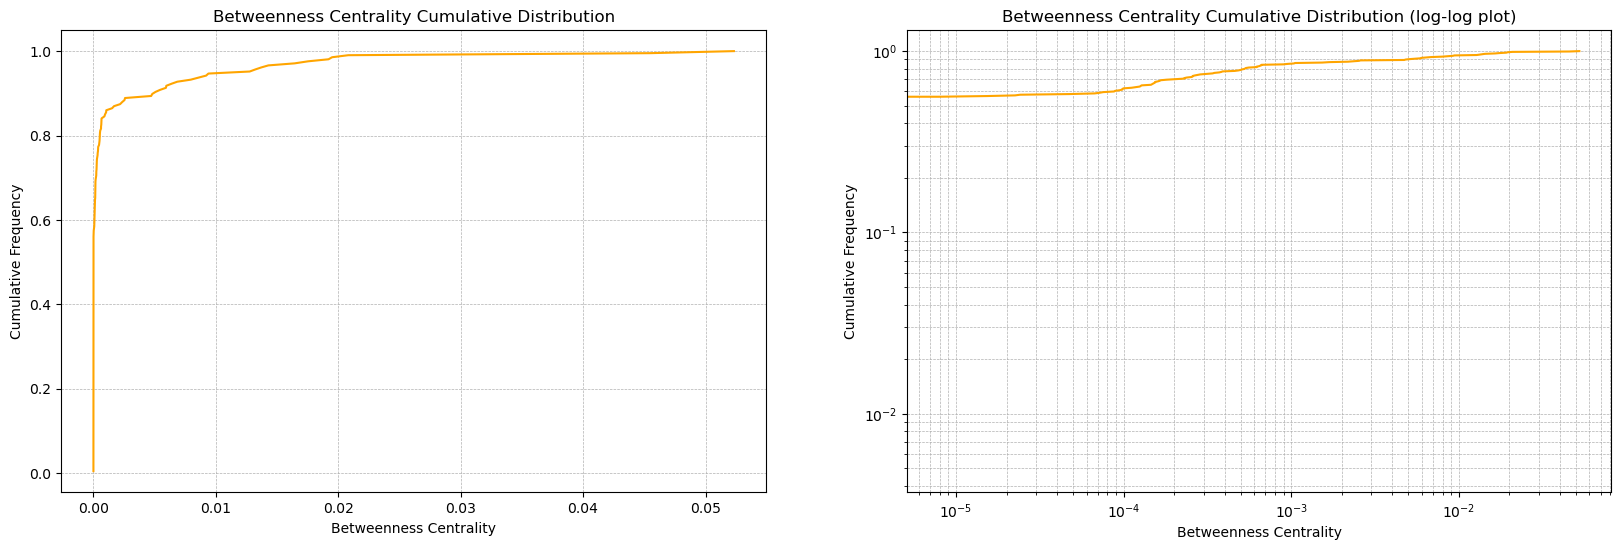

In [53]:
print("-----Exports Network-----")
cumulative_distribution(betweenness_centrality_values_export,type='Betweenness', color='skyblue')
print("\n-----Imports Network-----")
cumulative_distribution(betweenness_centrality_values_import,type='Betweenness', color='orange')

## Closeness centrality

Closeness centrality measures how quickly a node can reach all other nodes in the network. In a trade network, it indicates how efficiently a country can access other countries' markets. A higher closeness centrality suggests that a country is geographically or economically well-positioned to trade with others, reducing trade costs and improving market access.

-----Exports Network-----


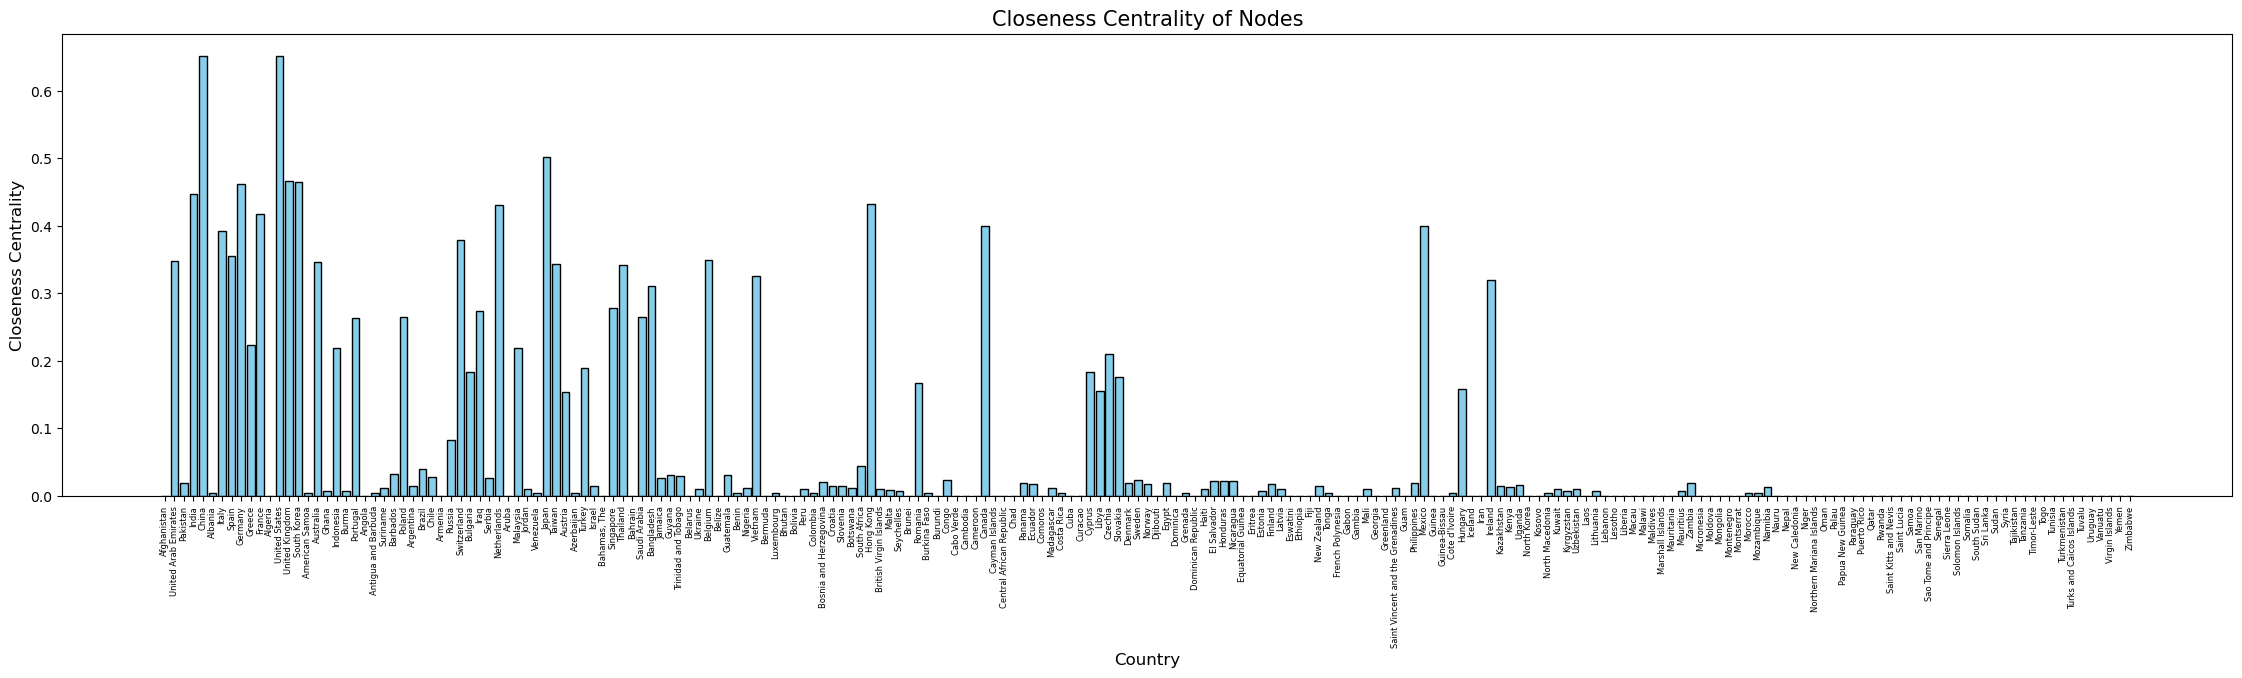

Nodes (Countries) with High Closeness Centrality (> 0.5):
China: 0.6518
United States: 0.6518
Japan: 0.5025

-----Imports Network-----


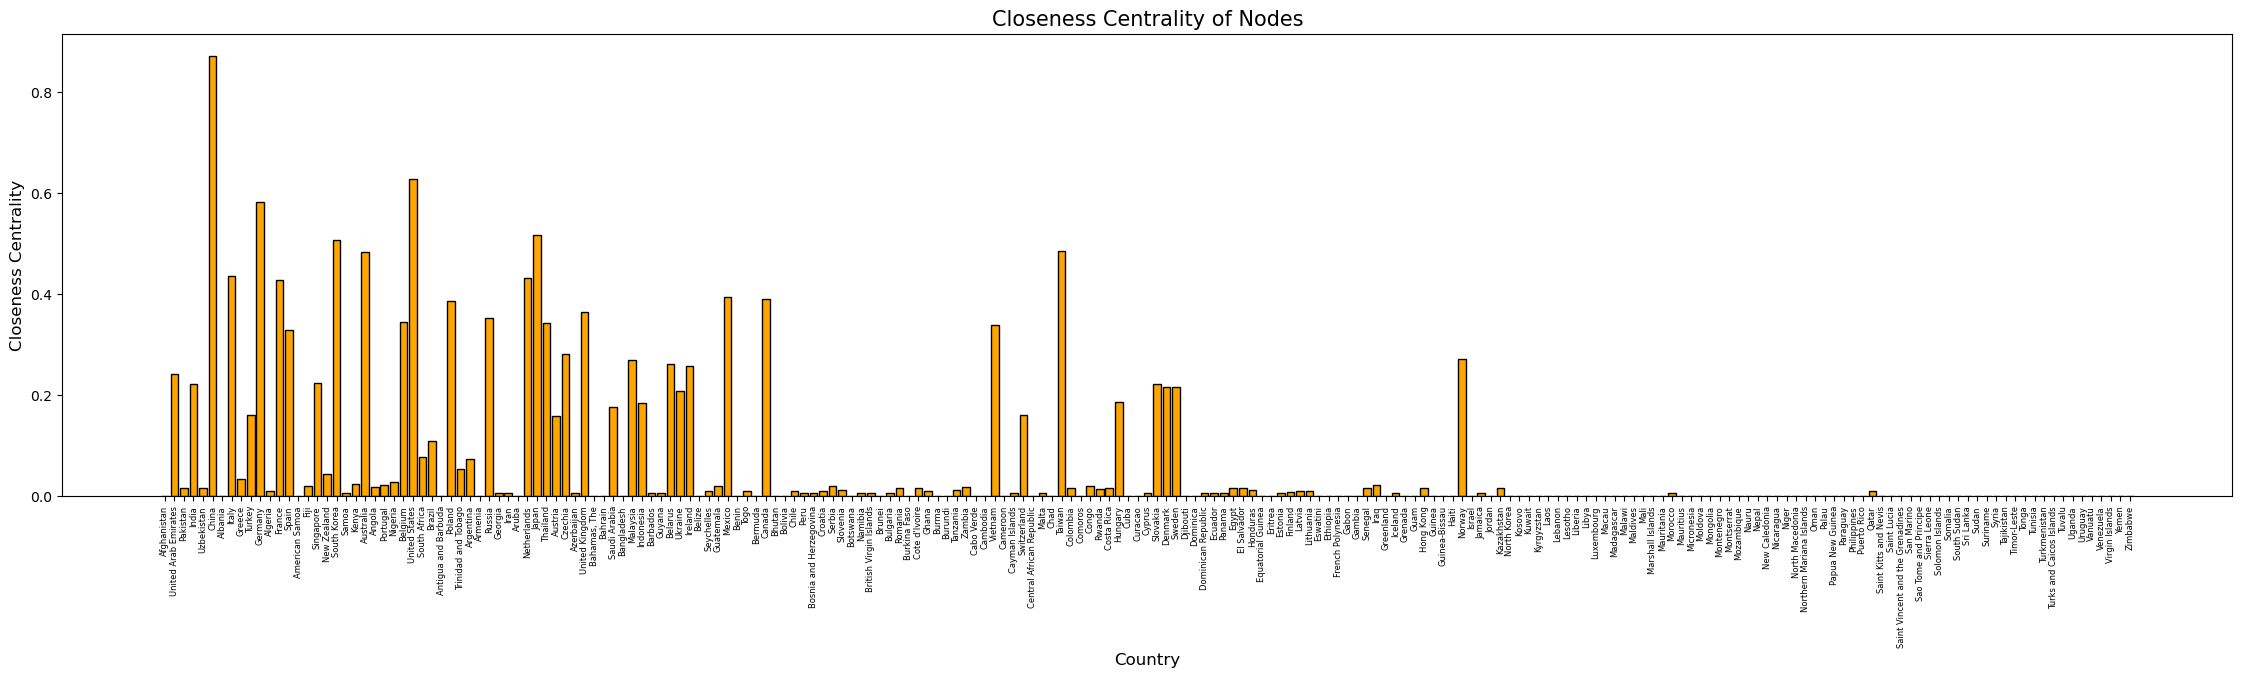

Nodes (Countries) with High Closeness Centrality (> 0.5):
China: 0.8718
Germany: 0.5829
South Korea: 0.5062
United States: 0.6277
Japan: 0.5178


In [103]:
closeness_centrality_export = nx.closeness_centrality(G_export)
closeness_centrality_import = nx.closeness_centrality(G_import)
closeness_centrality_values_export = list(closeness_centrality_export.values())
closeness_centrality_values_import = list(closeness_centrality_import.values())

print("-----Exports Network-----")
high_closeness_nodes_export = centrality(closeness_centrality_export, closeness_centrality_values_export, type='Closeness Centrality',threshold=0.5, color='skyblue')
print("\n-----Imports Network-----")
high_closeness_nodes_import = centrality(closeness_centrality_import, closeness_centrality_values_import, type='Closeness Centrality',threshold=0.5, color='orange')

### Closeness centrality distribution

-----Exports Network-----


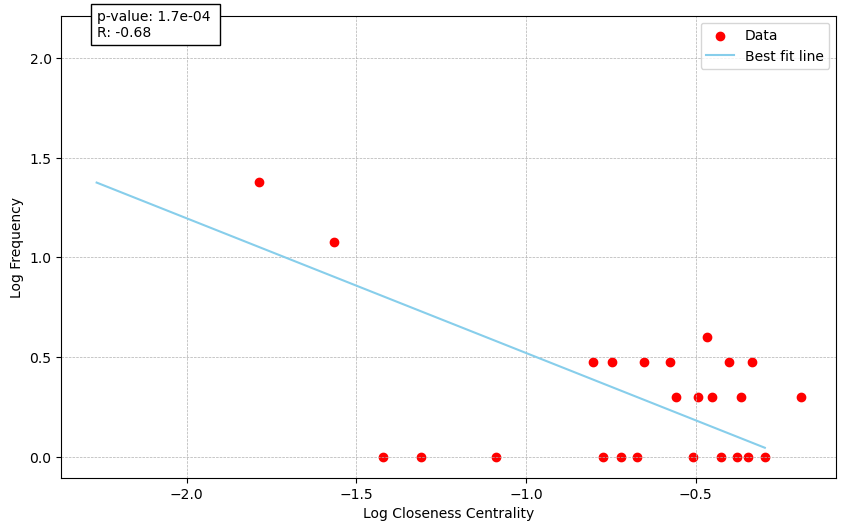

The slope of the line is: -0.6758966469357606

-----Imports Network-----


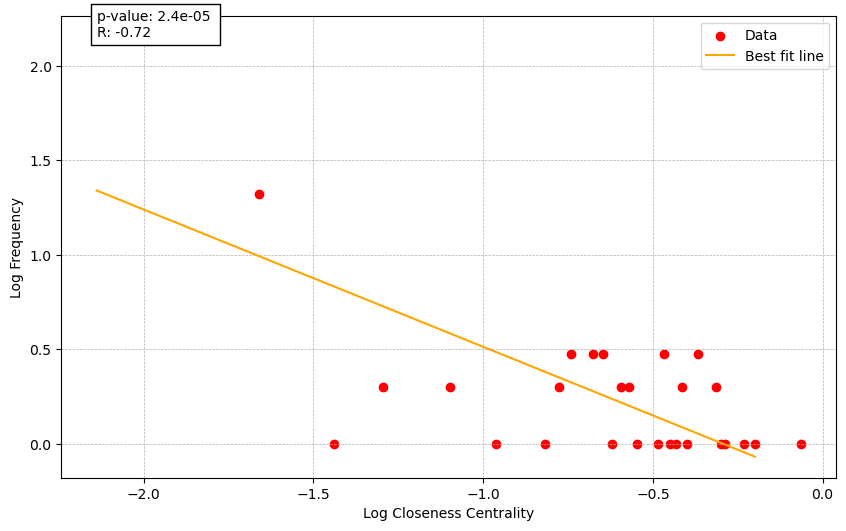

The slope of the line is: -0.7272260243601809


In [57]:
print("-----Exports Network-----")
slope_c_export = plot_centrality_power_law(closeness_centrality_values_export, G_export, bins=60, type='Closeness', color='skyblue')
print("\n-----Imports Network-----")
slope_c_import = plot_centrality_power_law(closeness_centrality_values_import, G_import, bins=60, type='Closeness', color='orange')

## Pagerank

PageRank is a measure of the importance of nodes in a network, taking into account both the quantity and quality of incoming links. In the context of trade, it indicates the overall importance of a country within the global trade network. A high PageRank score suggests that a country is a significant hub, attracting substantial trade from other countries.

-----Exports Network-----


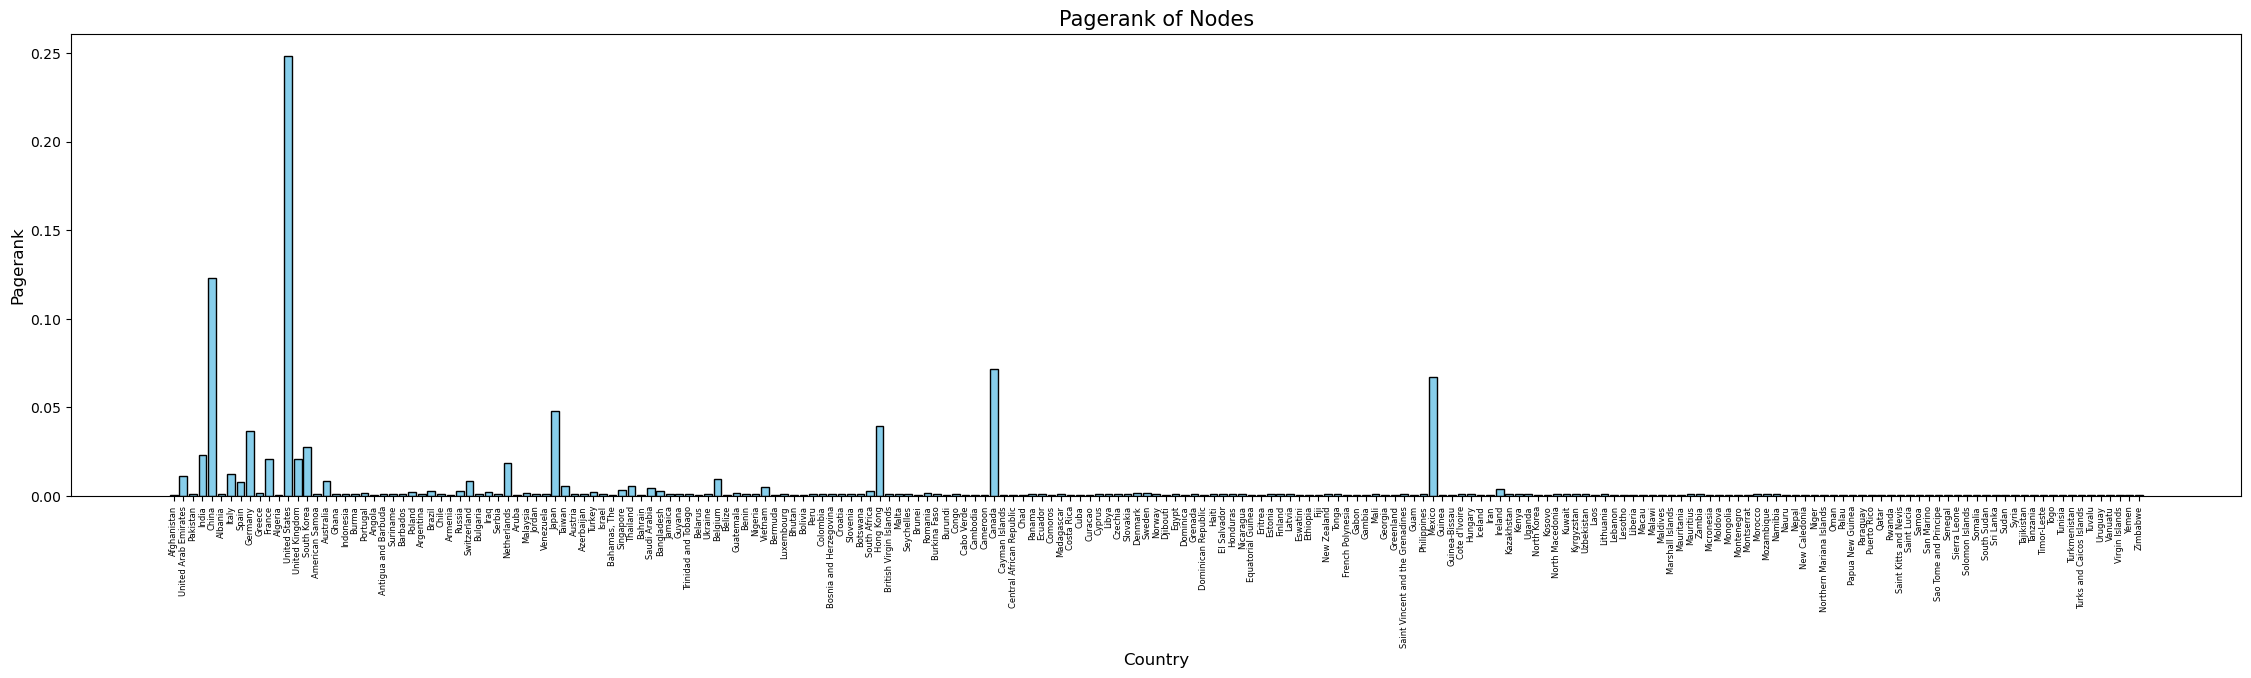

Nodes (Countries) with High Pagerank (> 0.04):
China: 0.1229
United States: 0.2484
Japan: 0.0479
Canada: 0.0716
Mexico: 0.0669

-----Imports Network-----


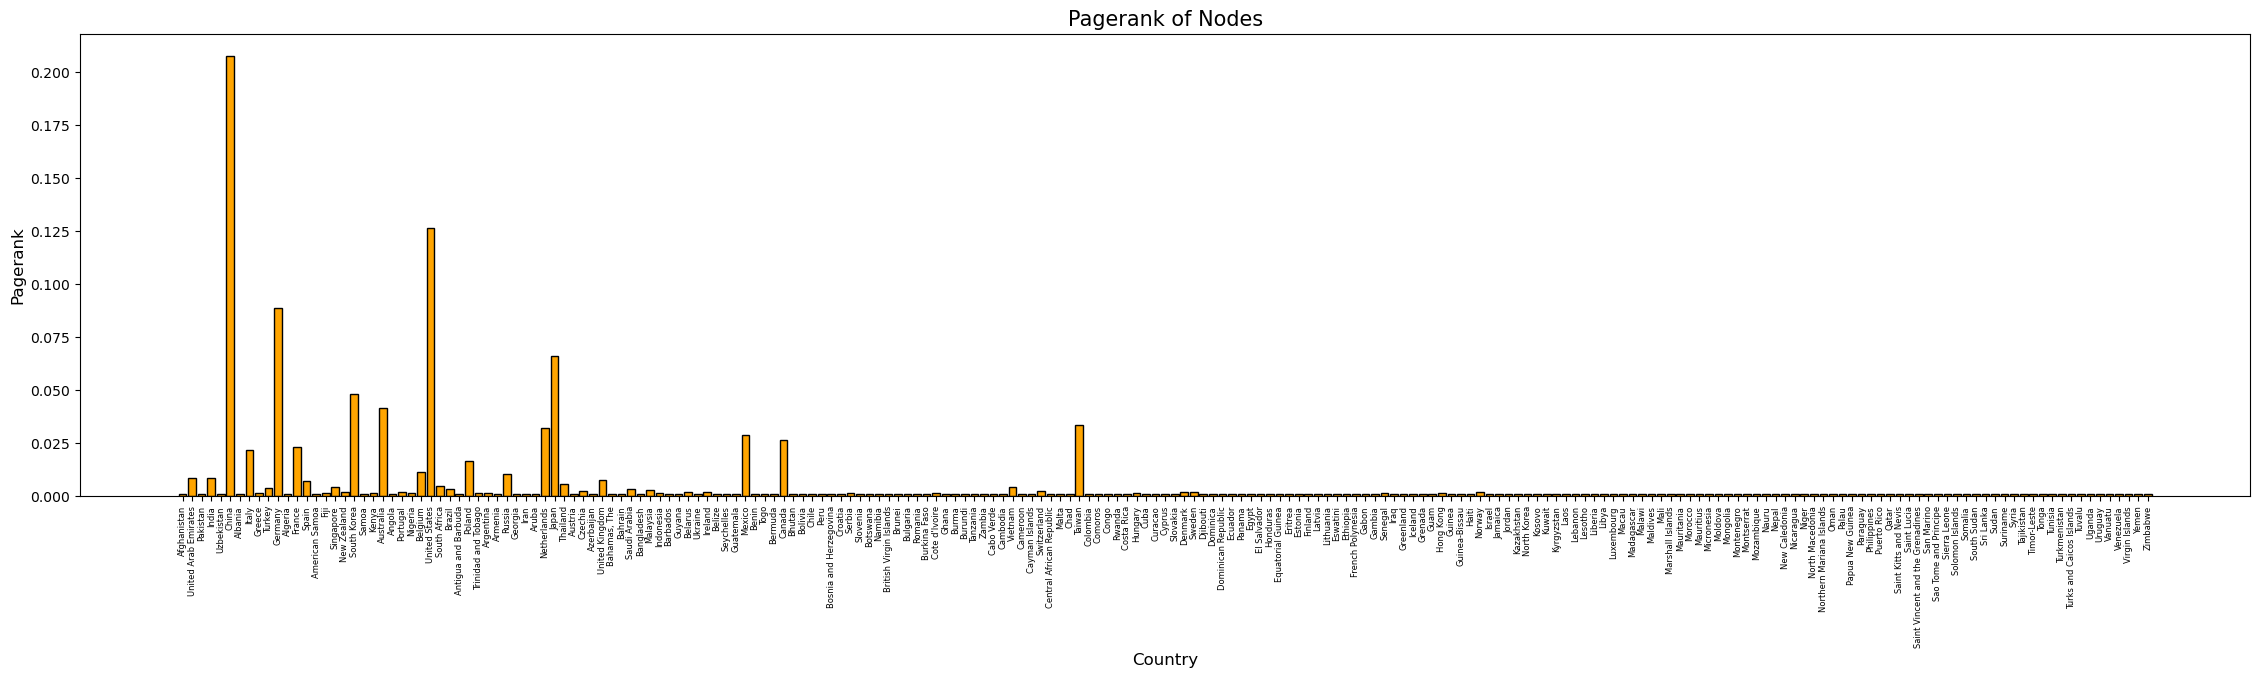

Nodes (Countries) with High Pagerank (> 0.04):
China: 0.2075
Germany: 0.0887
South Korea: 0.0478
Australia: 0.0416
United States: 0.1264
Japan: 0.0661


In [111]:
G_noloops_export = G_export.copy()
G_noloops_import = G_import.copy()

G_noloops_export.remove_edges_from(nx.selfloop_edges(G_noloops_export))  # Remove self-loops
G_noloops_import.remove_edges_from(nx.selfloop_edges(G_noloops_import))


pagerank_export = nx.pagerank(G_noloops_export)
pagerank_import = nx.pagerank(G_noloops_import)
pagerank_values_export = list(pagerank_export.values())
pagerank_values_import = list(pagerank_import.values())

print("-----Exports Network-----")
high_pagerank_nodes_export = centrality(pagerank_export, pagerank_values_export, type='Pagerank',threshold=0.04, color='skyblue')
print("\n-----Imports Network-----")
high_pagerank_nodes_import = centrality(pagerank_import, pagerank_values_import, type='Pagerank',threshold=0.04, color='orange')

## Local Clustering coefficient

The clustering coefficient measures the degree to which nodes in a graph tend to cluster together. In trade networks, it indicates the extent to which countries tend to form trade blocs or regional trade agreements. A higher clustering coefficient suggests that countries tend to trade more with their neighbors, forming tightly-knit clusters.

-----Exports Network-----


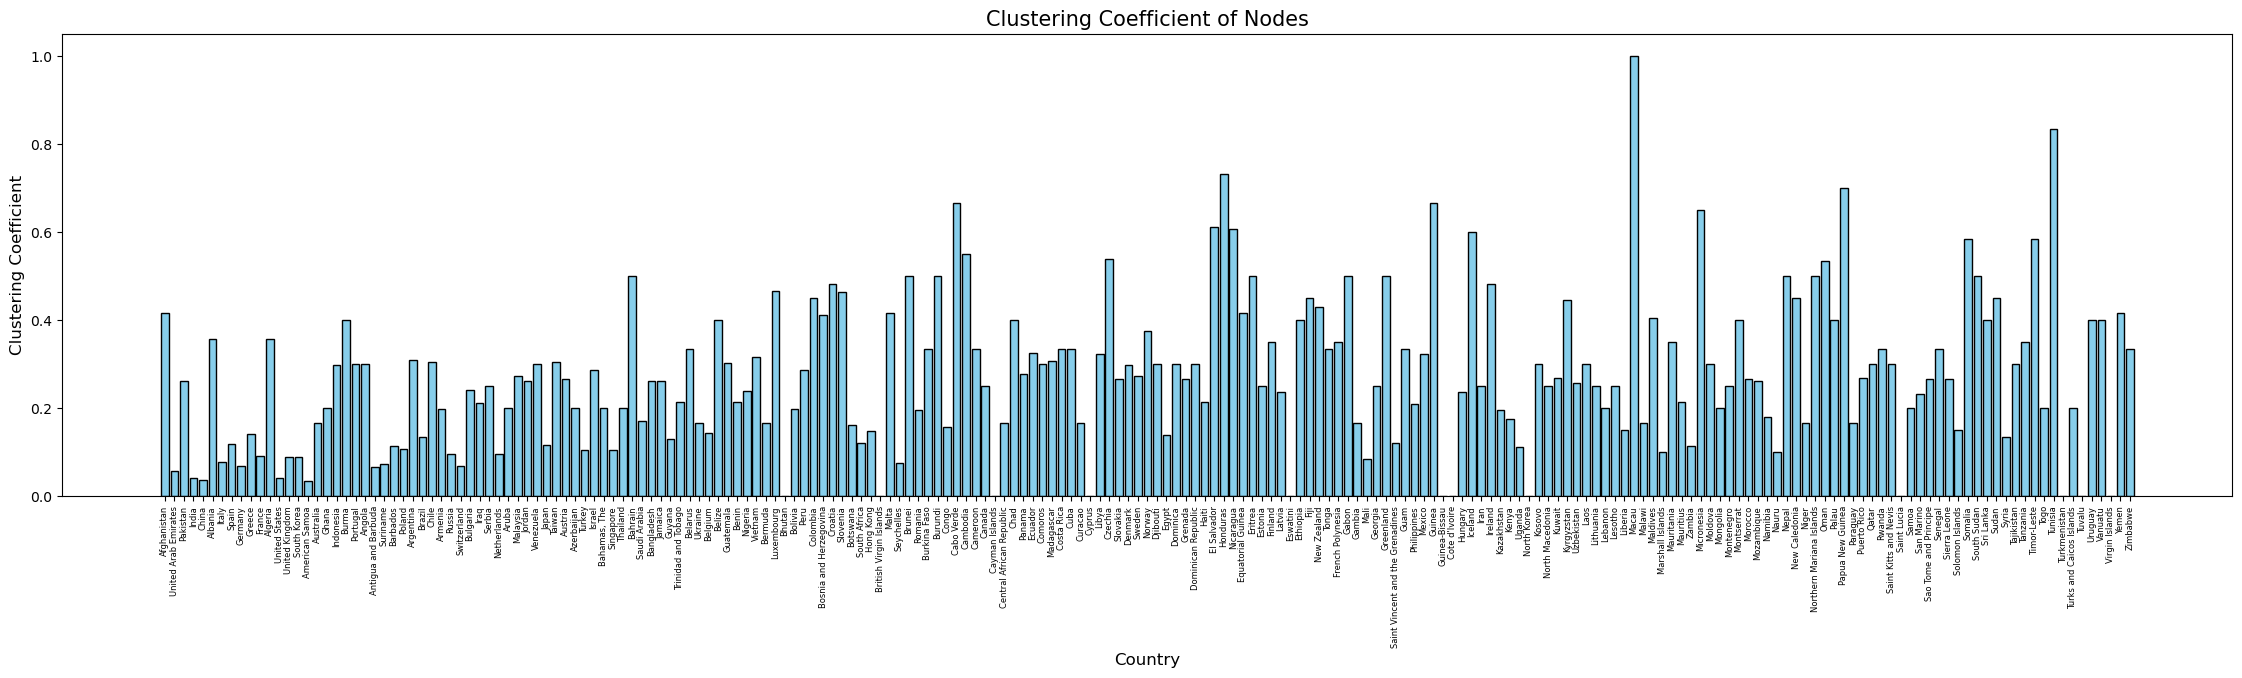

Nodes (Countries) with High Clustering Coefficient (> 0.69):
Honduras: 0.7308
Macau: 1.0000
Papua New Guinea: 0.7000
Tunisia: 0.8333

-----Imports Network-----


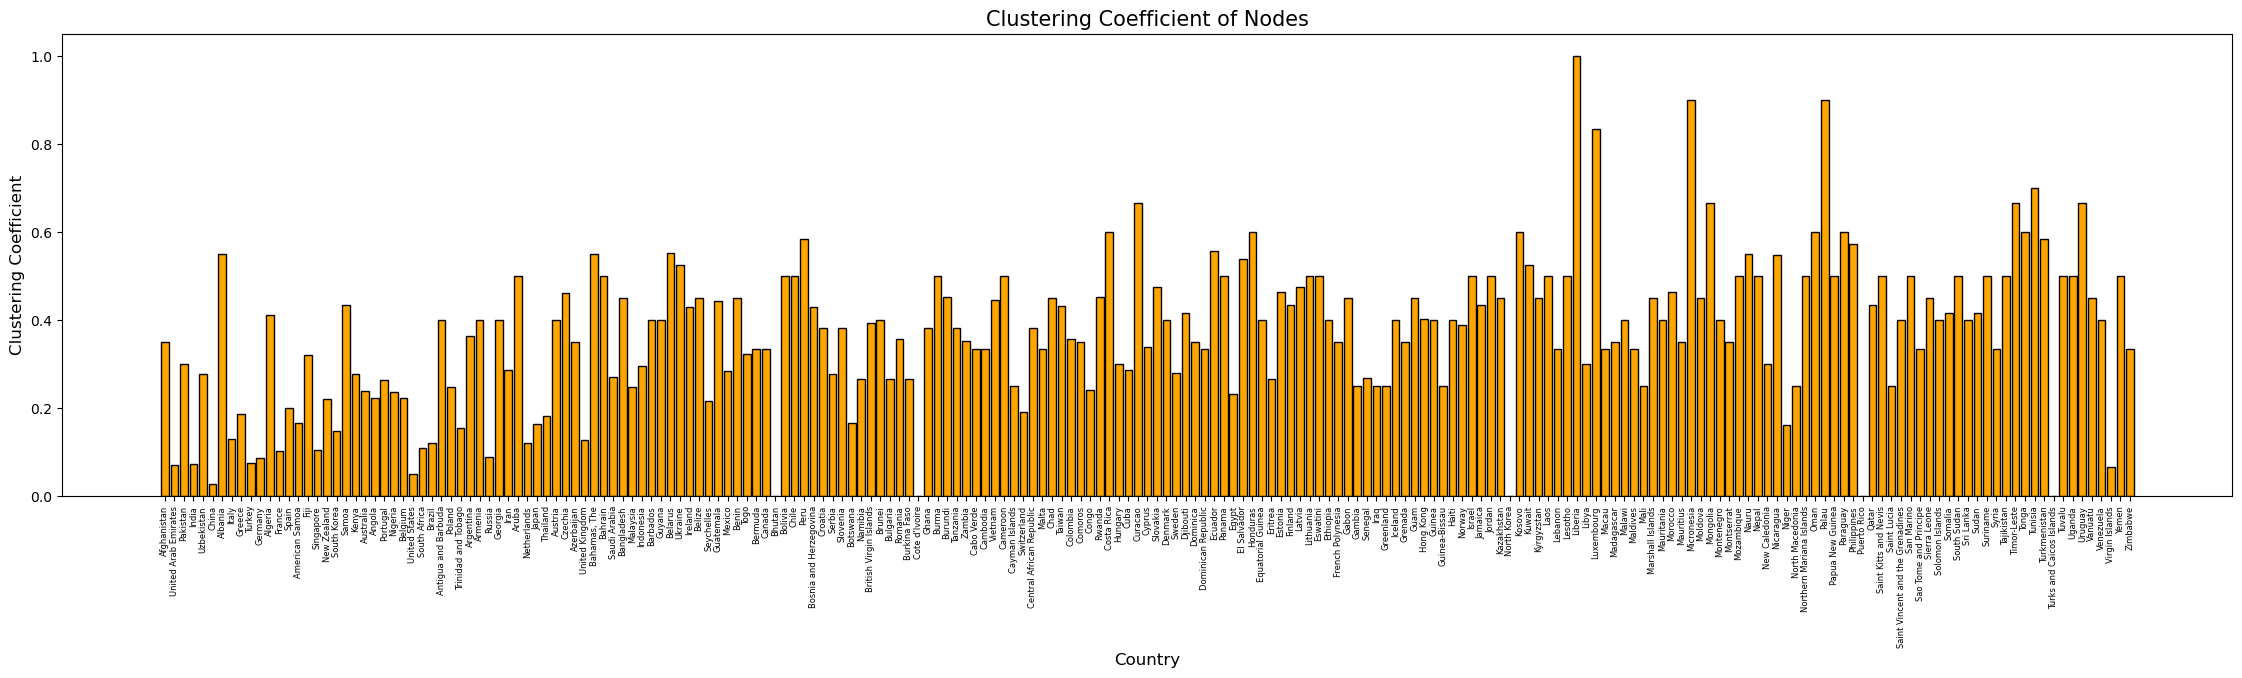

Nodes (Countries) with High Clustering Coefficient (> 0.69):
Liberia: 1.0000
Luxembourg: 0.8333
Micronesia: 0.9000
Palau: 0.9000
Tunisia: 0.7000


In [117]:
clustering_coeffs_export = nx.clustering(G_export)
clustering_coeffs_import = nx.clustering(G_import)
clustering_coeffs_values_export = list(clustering_coeffs_export.values())
clustering_coeffs_values_import = list(clustering_coeffs_import.values())

print("-----Exports Network-----")
high_clustering_nodes_export = centrality(clustering_coeffs_export, clustering_coeffs_values_export, type='Clustering Coefficient',threshold=0.69, color='skyblue')
print("\n-----Imports Network-----")
high_clustering_nodes_import = centrality(clustering_coeffs_import, clustering_coeffs_values_import, type='Clustering Coefficient',threshold=0.69, color='orange')

### Correlation between Local Clustering Coefficient and Degree Centrality

Is a measure of how these two properties are related across the nodes of a graph. Degree centrality measures the number of connections a node has, while the local clustering coefficient measures the tendency of a node's neighbors to be connected with each other. By examining their correlation, we can gain insights into the structural properties of the graph.

-----Exports Network-----
Pearson correlation coefficient: -0.3323
P-value: 9.9960e-07


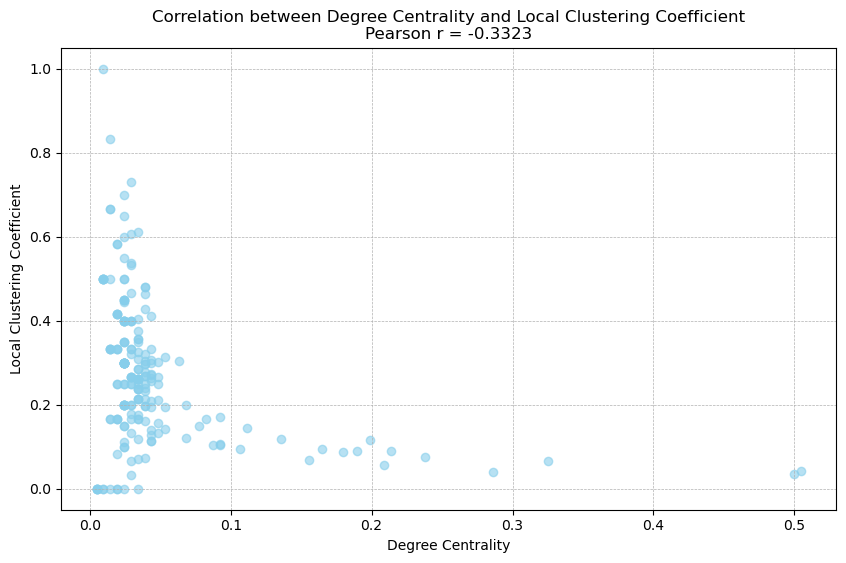


-----Imports Network-----
Pearson correlation coefficient: -0.4171
P-value: 4.0351e-10


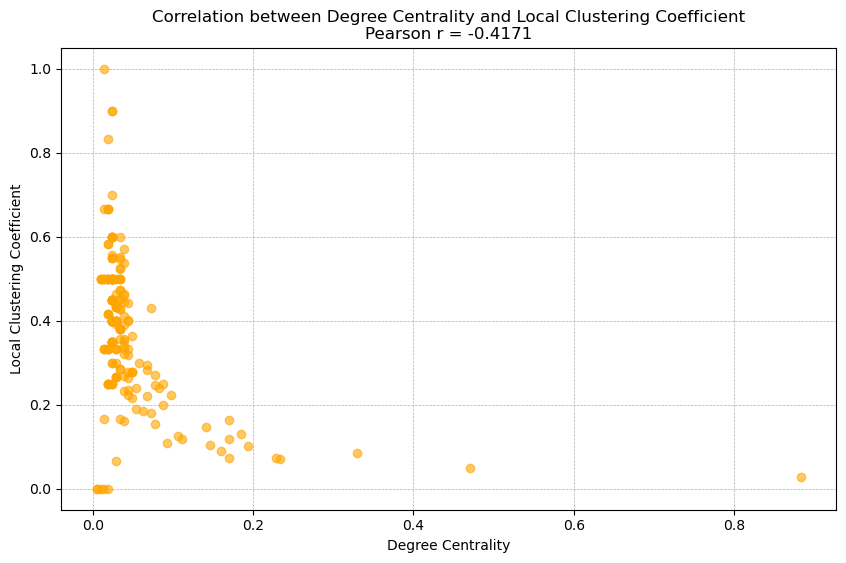

In [65]:
# Pearson correlation coefficient
def correlation_cd(clustering_coeffs_values, degree_centrality_values, color='skyblue'):
    correlation, p_value = stats.pearsonr(clustering_coeffs_values, degree_centrality_values)
    
    print(f"Pearson correlation coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")
    
    # Plotting the correlation
    plt.figure(figsize=(10, 6))
    plt.scatter(degree_centrality_values, clustering_coeffs_values, color=color, alpha=0.6)
    plt.xlabel('Degree Centrality')
    plt.ylabel('Local Clustering Coefficient')
    plt.title(f'Correlation between Degree Centrality and Local Clustering Coefficient\nPearson r = {correlation:.4f}')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()
    return correlation, p_value

print("-----Exports Network-----")
correlation_export, p_value_export = correlation_cd(clustering_coeffs_values_export, degree_centrality_values_export, color='skyblue')
print("\n-----Imports Network-----")
correlation_import, p_value_import = correlation_cd(clustering_coeffs_values_import, degree_centrality_values_import, color='orange')

Cliques

Finding cliques in a graph can be useful for understanding the structure and relationships within the graph, such as identifying tightly knit groups of nodes, which might represent communities or highly interconnected subgraphs.

In [76]:
G_undirected_export = G_export.to_undirected()
G_undirected_import = G_import.to_undirected()

cliques_export = list(nx.find_cliques(G_undirected_export))
cliques_import = list(nx.find_cliques(G_undirected_import))

th=6
large_cliques_export = [clique for clique in cliques_export if len(clique) >= th]
large_cliques_import = [clique for clique in cliques_import if len(clique) >= th]

print(f"Clique(s) larger than {th} nodes in the Exports graph:")
for clique in large_cliques_export:
    print(clique)

print(f"Clique(s) larger than {th} nodes in the Imports graph:")
for clique in large_cliques_import:
    print(clique)


largest_clique_export = max(cliques_export, key=len)
largest_clique_import = max(cliques_import, key=len)
print("\nLargest clique in the Exports graph: " + str(largest_clique_export) + " with size: " + str(len(largest_clique_export)))
print("\nLargest clique in the Imports graph: " + str(largest_clique_import) + " with size: " + str(len(largest_clique_import)))

Clique(s) larger than 6 nodes in the Exports graph:
['Slovenia', 'Italy', 'Germany', 'Austria', 'Bosnia and Herzegovina', 'Croatia']
['Belgium', 'United States', 'Netherlands', 'Germany', 'Ireland', 'United Kingdom']
['China', 'Papua New Guinea', 'Australia', 'Taiwan', 'South Korea', 'Japan']
['Spain', 'United States', 'Germany', 'Libya', 'Italy', 'France']
Clique(s) larger than 6 nodes in the Imports graph:
['China', 'Russia', 'Germany', 'Poland', 'Belarus', 'Ukraine']
['China', 'Hungary', 'Italy', 'Germany', 'Poland', 'Netherlands']
['China', 'Hungary', 'Italy', 'Germany', 'Poland', 'Romania']
['China', 'Tunisia', 'France', 'Italy', 'Algeria', 'Germany']
['China', 'Burundi', 'India', 'United Arab Emirates', 'Kenya', 'Saudi Arabia']
['China', 'Algeria', 'Italy', 'Germany', 'France', 'Spain']
['China', 'United States', 'Mexico', 'Guatemala', 'Nicaragua', 'Honduras', 'El Salvador']
['China', 'United States', 'Mexico', 'Guatemala', 'Nicaragua', 'Costa Rica']
['China', 'United States', 'T

K-core and core periphery structures

K-core decomposition is used to identify subgraphs within the network that are more densely connected. The k-core of a graph is a maximal subgraph in which each node has at least degree k. By analyzing k-cores, we can identify the most influential and interconnected nodes within the trade network. These core nodes are crucial for understanding the backbone of the trade network, as they often represent countries with strong and diverse trade relationships.

In [71]:
def kcores(G_noloops, a, b):
    k_values = range(a, b)  # Define the k values
    
    for k in k_values:
        k_core_subgraph = nx.k_core(G_noloops, k)
        k_core_nodes = k_core_subgraph.nodes()
        if len(k_core_nodes) > 0:  # Only print non-empty k-cores
            print(f"\nNodes in the {k}-core:", k_core_nodes)
    return k_core_nodes
    
print("-----Exports Network-----")
k_core_nodes_export = kcores(G_noloops_export, 4, 10)
print("\n-----Imports Network-----")
k_core_nodes_import = kcores(G_noloops_import, 4, 10)

-----Exports Network-----

Nodes in the 4-core: ['Afghanistan', 'United Arab Emirates', 'Pakistan', 'India', 'China', 'Albania', 'Italy', 'Spain', 'Germany', 'Greece', 'France', 'Algeria', 'United States', 'United Kingdom', 'South Korea', 'American Samoa', 'Australia', 'Ghana', 'Indonesia', 'Burma', 'Portugal', 'Angola', 'Antigua and Barbuda', 'Suriname', 'Barbados', 'Poland', 'Argentina', 'Brazil', 'Chile', 'Armenia', 'Russia', 'Switzerland', 'Bulgaria', 'Iraq', 'Serbia', 'Netherlands', 'Aruba', 'Malaysia', 'Jordan', 'Venezuela', 'Japan', 'Taiwan', 'Austria', 'Azerbaijan', 'Turkey', 'Israel', 'Bahamas, The', 'Singapore', 'Thailand', 'Bahrain', 'Saudi Arabia', 'Bangladesh', 'Jamaica', 'Guyana', 'Trinidad and Tobago', 'Ukraine', 'Belgium', 'Belize', 'Guatemala', 'Benin', 'Nigeria', 'Vietnam', 'Luxembourg', 'Bolivia', 'Peru', 'Colombia', 'Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'Botswana', 'South Africa', 'Hong Kong', 'British Virgin Islands', 'Malta', 'Seychelles', 'Brunei', 'Ro

Assortative mixing by degree

Assortative mixing by degree measures the tendency of nodes to connect to other nodes that are similar in degree. In the context of trade networks, this can indicate whether countries with similar trade volumes tend to trade with each other. High assortative mixing suggests that countries with high trade volumes (high-degree nodes) tend to trade more with other high-volume countries, while low assortative mixing might indicate a more diverse set of trade partners irrespective of trade volume.

In [86]:
assortativity_coefficient_export = nx.degree_assortativity_coefficient(G_export)
assortativity_coefficient_import = nx.degree_assortativity_coefficient(G_import)

print(f"Assortative Mixing by Degree (Exports Network): {assortativity_coefficient_export:.4f}")
print(f"Assortative Mixing by Degree (Imports Network): {assortativity_coefficient_import:.4f}")

Assortative Mixing by Degree (Exports Network): -0.0221
Assortative Mixing by Degree (Imports Network): -0.1176


Visualize the degree correlations

Degree correlation measures the relationship between a node's degree and the average degree of its neighbors. This can help in understanding how nodes are connected within the network. In trade networks, it helps to analyze whether countries with many trade connections (high-degree nodes) tend to be connected to other well-connected countries or to less connected countries. This information can reveal the structural properties of the trade network, such as the presence of hubs or clusters.

-----Exports Network-----


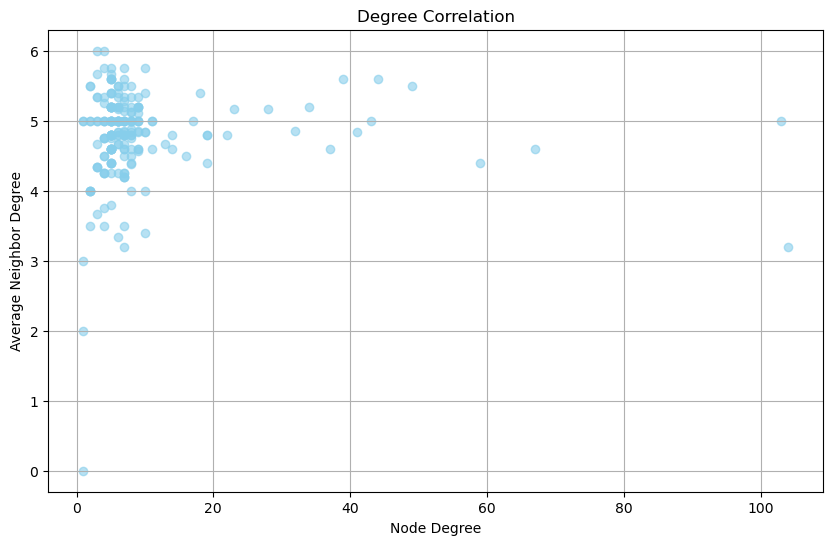


-----Imports Network-----


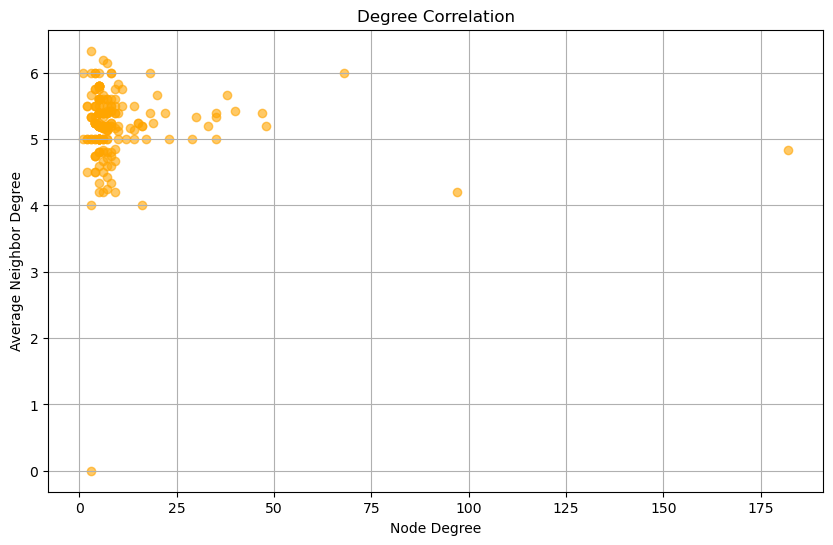

In [69]:
def deg_cor(G, color='skyblue'):
    # Compute the degree of each node
    degree = dict(G.degree())
    
    # Compute the average neighbor degree for each node
    avg_neighbor_degree = nx.average_neighbor_degree(G)
    
    # Prepare data for plotting
    degrees = list(degree.values())
    avg_neighbor_degrees = [avg_neighbor_degree[node] for node in G.nodes()]
    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(degrees, avg_neighbor_degrees, color=color, alpha=0.6)
    plt.xlabel('Node Degree')
    plt.ylabel('Average Neighbor Degree')
    plt.title('Degree Correlation')
    plt.grid(True)
    plt.show()

print("-----Exports Network-----")
deg_cor(G_export)
print("\n-----Imports Network-----")
deg_cor(G_import, color='orange')

## Density

Graph density is a measure of how many edges are present in the graph compared to the maximum possible number of edges. It gives a sense of how "dense" or "sparse" the network is. In the context of trade networks, density indicates the overall connectivity among countries. A denser network suggests that there are more trade relationships between countries, indicating a more interconnected and potentially robust global trade system.

In [89]:
graph_density_export = nx.density(G_export)
graph_density_import = nx.density(G_import)

print(f"Graph Density (Exports): {graph_density_export:.4f}")
print(f"Graph Density (Imports): {graph_density_import:.4f}")

Graph Density (Exports): 0.0228
Graph Density (Imports): 0.0235


## Gephi CSV Exports

In [137]:
# Export nodes (attributes) to CSV
def export_csv_nodes(G, degree_centrality, eigenvector_centrality,betweenness_centrality, closeness_centrality, pagerank, clustering_coeffs, filename= 'measures.csv'):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Node', 'Degree', 'Eigenvector', 'Betweenness', 'Closeness', 'PageRank', 'ClusteringCoefficient']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for node in G.nodes():
            writer.writerow({
                'Node': node, 
                'Degree': degree_centrality[node],
                'Eigenvector': eigenvector_centrality[node],
                'Betweenness': betweenness_centrality[node],
                'Closeness': closeness_centrality[node],
                'PageRank': pagerank[node], 
                'ClusteringCoefficient': clustering_coeffs[node],
            })
    print(f"Nodes CSV has been saved as {filename}")

# Export edges (structure) to CSV
def export_csv_edges(G, filename):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Source', 'Target', 'Weight']  # Add more fields as per your edge attributes
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for edge in G.edges(data=True):
            writer.writerow({
                'Source': edge[0],
                'Target': edge[1],
                'Weight': edge[2]['weight'] if 'weight' in edge[2] else 1,  # Example for edge weight
                # Add more attributes as needed
            })

    print(f"Edges CSV has been saved as {filename}")

export_csv_nodes(G_export, degree_centrality_export, eigenvector_centrality_export, betweenness_centrality_export, closeness_centrality_export, pagerank_export, clustering_coeffs_export, filename= 'nodes_export.csv')
export_csv_nodes(G_import, degree_centrality_import, eigenvector_centrality_import, betweenness_centrality_import, closeness_centrality_import, pagerank_import, clustering_coeffs_import, filename= 'nodes_import.csv')
export_csv_edges(G_export, 'edges_export.csv')
export_csv_edges(G_import, 'edges_import.csv')


Nodes CSV has been saved as nodes_export.csv
Nodes CSV has been saved as nodes_import.csv
Edges CSV has been saved as edges_export.csv
Edges CSV has been saved as edges_import.csv
